In [13]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from pprint import pprint
import astropy
from astropy import units as u
from scipy.optimize import minimize
print astropy.__version__
import math
import pandas as pd

import matplotlib 
%matplotlib notebook

from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

2.0.2


In [2]:
class spectral_order:
    def __init__(self,wav,flux,error,order_number):
        self.order = order_number
        self.wav = wav
        self.flux_ergs = flux
        self.flux_watts = flux*10.
        self.error_ergs = error
        self.error_watts = error*10.
        self.snr = flux/error
        
        self.wavfluxmap = {wav[i]: flux[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.waverrmap = {wav[i]: error[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        self.wavsnrmap = {wav[i]: self.snr[i] for i in range(len(wav)) if not math.isnan(wav[i])}
        

class arcoiris_spectrum(object):
    def __init__(self, name, data, date):
        ordernames = ['order3','order4','order5','order6','order7','order8']

        times_order_has_been_read = 0
        orders_read = 0
        ordernumbers = [3,4,5,6,7,8]
        
        orderwav = []
        orderflux = []
        ordererr = []
        
        fullwav = []
        fullflux = []
        fullerr = []
        
        for line in data: 
            if 'Order' in line:
                times_order_has_been_read += 1
                if times_order_has_been_read > 1:
                    orders_read += 1
                ordernumber = ordernumbers[orders_read]
                #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
                if len(orderwav) > 0:
                    orderwavvec = np.array(orderwav)
                    orderfluxvec = np.array(orderflux)
                    ordererrvec = np.array(ordererr)
                    
                    #print ordernames[orders_read-1]
                    setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                    
                    orderwav = []
                    orderflux = []
                    ordererr = []
                    
            else:
                conts = line.split()
                orderwav.append(float(conts[0]))
                orderflux.append(float(conts[1]))
                ordererr.append(float(conts[2]))
                fullwav.append(float(conts[0]))
                fullflux.append(float(conts[1]))
                fullerr.append(float(conts[2]))
                
                
        #print 'Out of loop'
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        orders_read += 1
        #print ordernumber, times_order_has_been_read, orders_read, len(orderwav)
        
        setattr(self,ordernames[orders_read-1],spectral_order(orderwavvec, orderfluxvec, ordererrvec, ordernumber))
                
        self.orderlist = [self.order3, self.order4, self.order5, self.order6, self.order7, self.order8]
        
        self.fullwav = np.array(fullwav)
        self.fullflux = np.array(fullflux)
        self.fullerr = np.array(fullerr)
        self.fullsnr = self.fullflux/self.fullerr
        
        self.objectname = name
        self.objectdate = date
        
        
                
    def plot_spectrum(self,snrthreshold,use_watts,temp_spec=None,f=None):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        for order in self.orderlist:
            orderwav_plot = []
            orderflux_plot = []
            for i in range(len(order.wav)):
                if order.snr[i] > snrthreshold:
                    orderwav_plot.append(order.wav[i])
                    if use_watts:
                        orderflux_plot.append(order.flux_watts[i])
                    else:
                        orderflux_plot.append(order.flux_ergs[i])
            ax.plot(orderwav_plot, orderflux_plot)

        if temp_spec != None:
            ax.plot(temp_spec.short_wavelength,temp_spec.short_flux_density*f)            
            
        ax.set_xlim([0.8,2.4])
        
        #if use_watts:
        #    ax.set_ylim([0.,1.e-13])
        #else:
        #    ax.set_ylim([0.,1.e-14])
        
        ax.set_xlabel(r'Wavelength ($\mu$m)')
        if use_watts:
            ax.set_ylabel(r'Flux ($W/m^{2}/\mu m$)')
        else:
            ax.set_ylabel(r'Flux ($ergs s^{-1} cm^{-2} \AA^{-1}$)')
        
        if temp_spec != None:
            ax.set_title(r'Comparison of ' + self.objectname + ' to template')
        else:
            ax.set_title(self.objectname)
            
            
        return fig


In [3]:
class arcoiris_merged_spectrum(object):
    
    def __init__(self, name, data, date):
        self.objectname = name
        self.obsdate = date
        
        tempwav = []
        tempflux = []
        temperr = []
        #tempsnr = []
        
        for line in data:
            conts = line.split()
            tempwav.append(float(conts[0]))
            tempflux.append(float(conts[1]))
            temperr.append(float(conts[2]))
            
        self.wav = np.array(tempwav)
        self.flux = np.array(tempflux)
        self.err = np.array(temperr)
        self.snr = self.flux/self.err
        
        self.flux_watts = self.flux*10.
        self.err_watts = self.err*10.
        
    def __str__(self):
        s = 'Wav Flux Err \n'
        for i in range(self.wav.size):
            s = s + str(self.wav[i]) + ' ' + str(self.flux[i]) + ' ' + str(self.err[i]) + '\n'
            
        return s
    
    def get_snr_cut_spectrum(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
    
    def get_snr_cut_spectrum_watts(self,snrthreshold):
        
        wav = np.array([self.wav[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        flux = np.array([self.flux_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        err = np.array([self.err_watts[i] for i in range(self.wav.size) if self.snr[i] > snrthreshold])
        
        return wav, flux, err
        
        
class spex_spectrum(object):
    def __init__(self, data):
        
        first_row_found = False
        first_row_index = -1
        linecount = 0
        while not first_row_found:
            if data[linecount][0] == '#':
                linecount += 1
            else:
                first_row_index = linecount
                first_row_found = True
                
        print 'First row found:', first_row_index
       
        spectral_data = data[first_row_index:]

        full_wavelength_list = []
        full_flux_density_list = []
        full_error_list = []        
        short_wavelength_list = []
        short_flux_density_list = []
        short_error_list = []
        long_wavelength_list = []
        long_flux_density_list = []
        long_error_list = []

        
        for line in spectral_data:
            comps = line.split()
            wav = float(comps[0])
            flux = float(comps[1])
            error = float(comps[2])
        
            if (wav < -900.) or (flux < -900.) or (error < -900.):
                continue

            full_wavelength_list.append(float(comps[0]))
            full_flux_density_list.append(float(comps[1]))
            full_error_list.append(float(comps[2]))
            
            if wav < 2.75:
                short_wavelength_list.append(float(comps[0]))
                short_flux_density_list.append(float(comps[1]))
                short_error_list.append(float(comps[2]))
            else:
                long_wavelength_list.append(float(comps[0]))
                long_flux_density_list.append(float(comps[1]))
                long_error_list.append(float(comps[2]))                
        
        self.full_wavelength = np.array(full_wavelength_list)
        self.full_flux_density = np.array(full_flux_density_list)
        self.full_error = np.array(full_error_list)
        
        self.short_wavelength = np.array(short_wavelength_list)
        self.short_flux_density = np.array(short_flux_density_list)
        self.short_error = np.array(short_error_list)
        self.long_wavelength = np.array(long_wavelength_list)
        self.long_flux_density = np.array(long_flux_density_list)
        self.long_error = np.array(long_error_list)
    
        return

In [4]:
def import_arcoiris_from_text(filename, name, date):
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_merged_spectrum(name, data, date)
    
    return spectrum


def import_arcoiris_spectrum_from_file(targetname, filename, date):
    
    with open(filename) as f:
        data = f.readlines()
        
    spectrum = arcoiris_spectrum(targetname, data, date)
    
    return spectrum


def import_spex_spectrum_from_file(filename):
    
    with open(filename) as f:
        imported_data = f.readlines()
        
    spectrum = spex_spectrum(imported_data)
    return spectrum

In [5]:
def insort(a, b, kind='mergesort'):
    # took mergesort as it seemed a tiny bit faster for my sorted large array try.
    c = np.concatenate((a, b)) # we still need to do this unfortunatly.
    c.sort(kind=kind)
    flag = np.ones(len(c), dtype=bool)
    np.not_equal(c[1:], c[:-1], out=flag[1:])
    return c[flag]

In [19]:
awi0005x3s_20171104_jband = import_arcoiris_from_text('AWI0005x3s_xtc_20171104_jband.txt','AWI0005x3s','2017-11-04')

jresponsedf = pd.read_csv('jresponse.csv',low_memory=False)
jresponsedata = jresponsedf.values

jresponsewav = jresponsedata[:,0]
jresponseweight = jresponsedata[:,1]

jcombinedgrid = insort(jresponsewav, awi0005x3s_20171104_jband.wav)

jresponseweight_combinedgrid = np.zeros(jcombinedgrid.size)
awi0005x3s_20171104_jband_combinedgrid = np.interp(jcombinedgrid, awi0005x3s_20171104_jband.wav, awi0005x3s_20171104_jband.flux_watts)

for i in range(jcombinedgrid.size):
    if (jcombinedgrid[i] > jresponsewav[0]) and (jcombinedgrid[i] < jresponsewav[-1]):
        jresponseweight_combinedgrid[i] = np.interp(jcombinedgrid[i], jresponsewav, jresponseweight)
        


<IPython.core.display.Javascript object>


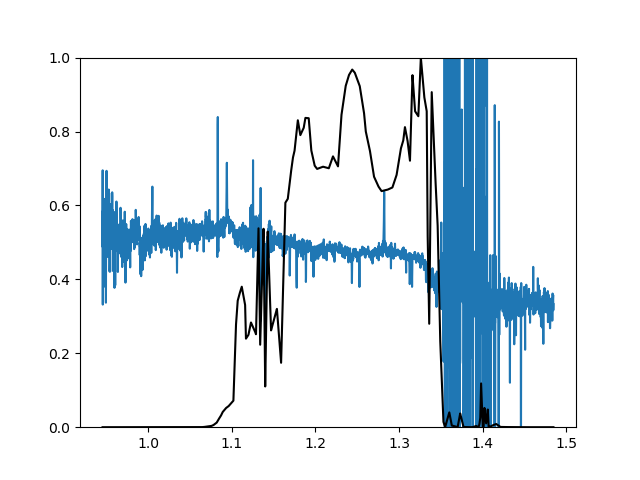

In [20]:
plt.figure()
plt.plot(jcombinedgrid, awi0005x3s_20171104_jband_combinedgrid/(4.0e-14))
plt.plot(jcombinedgrid, jresponseweight_combinedgrid,'k')
plt.ylim([0.,1.0])
plt.show()

In [43]:
jfilter_flux_numerator = np.trapz((awi0005x3s_20171104_jband_combinedgrid*jresponseweight_combinedgrid),jcombinedgrid)
jfilter_flux_denominator = np.trapz(jresponseweight_combinedgrid,jcombinedgrid)

print jfilter_flux_numerator
print jfilter_flux_denominator

jfilter_flux = jfilter_flux_numerator/jfilter_flux_denominator

print jfilter_flux
jmag_2mass = 12.999

zpj = 3.129e-9
zph = 1.133e-9
zpk = 4.283e-10

jflux_2mass = zpj*(10**(-0.4*jmag_2mass))

print jflux_2mass

jmultiplier = jflux_2mass / jfilter_flux

print jmultiplier

jfilter_flux_numerator_test = np.trapz((awi0005x3s_20171104_jband_combinedgrid*jresponseweight_combinedgrid*jmultiplier),jcombinedgrid)

jfilter_flux_test = jfilter_flux_numerator_test/jfilter_flux_denominator

print jfilter_flux_test/jflux_2mass


3.06208822472e-15
0.162433533856
1.88513304613e-14
1.97608473428e-14
1.0482468271
1.0


<IPython.core.display.Javascript object>


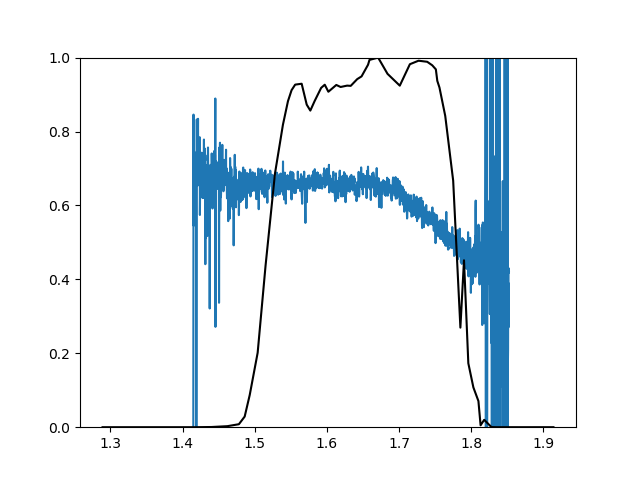

In [32]:
AWI0005x3s_20171104 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20171104_python.txt','2017-11-04')

plt.figure()
plt.plot(AWI0005x3s_20171104.order4.wav, AWI0005x3s_20171104.order4.flux_watts/(2.0e-14))
#plt.ylim([0.,2.0e-14])
plt.ylim([0.,1.])

hresponsedf = pd.read_csv('hresponse.csv',low_memory=False)
hresponsedata = hresponsedf.values

hresponsewav = hresponsedata[:,0]
hresponseweight = hresponsedata[:,1]

hcombinedgrid = insort(hresponsewav, AWI0005x3s_20171104.order4.wav)

plt.plot(hresponsewav, hresponseweight,'k')

plt.show()

<IPython.core.display.Javascript object>


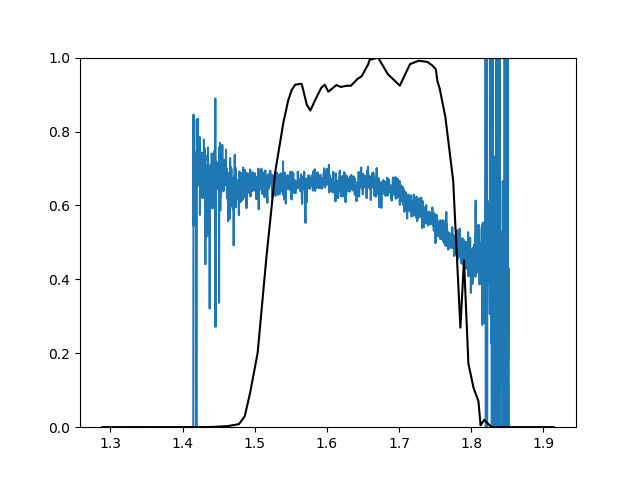

(0.25093715191052768, 0.25093845245398094, 5.1827188720654505e-06)

In [38]:
hresponseweight_combinedgrid = np.interp(hcombinedgrid, hresponsewav, hresponseweight)
awi0005x3s_20171104_hband_combinedgrid = np.zeros(hcombinedgrid.size)

for i in range(hcombinedgrid.size):
    if (hcombinedgrid[i] > AWI0005x3s_20171104.order4.wav[0]) and (hcombinedgrid[i] < AWI0005x3s_20171104.order4.wav[-1]):
        awi0005x3s_20171104_hband_combinedgrid[i] = np.interp(hcombinedgrid[i], AWI0005x3s_20171104.order4.wav, AWI0005x3s_20171104.order4.flux_watts)
        
plt.figure()
plt.plot(hcombinedgrid, awi0005x3s_20171104_hband_combinedgrid/(2.0e-14))
plt.plot(hcombinedgrid, hresponseweight_combinedgrid,'k')
plt.ylim([0.,1.0])
plt.show()

shortgrid = np.array([x for x in hcombinedgrid if (x > AWI0005x3s_20171104.order4.wav[0]) and (x < AWI0005x3s_20171104.order4.wav[-1])])
shortresponse = np.array([hresponseweight_combinedgrid[i] for i in range(hcombinedgrid.size) if (hcombinedgrid[i] > AWI0005x3s_20171104.order4.wav[0]) and (hcombinedgrid[i] < AWI0005x3s_20171104.order4.wav[-1])])

shortgridint = np.trapz(shortresponse, x=shortgrid)
fullgridint = np.trapz(hresponseweight_combinedgrid, x=hcombinedgrid)

shortgridint,fullgridint,(1-(shortgridint/fullgridint))

In [42]:
hfilter_flux_numerator = np.trapz((awi0005x3s_20171104_hband_combinedgrid*hresponseweight_combinedgrid),hcombinedgrid)
hfilter_flux_denominator = np.trapz((hresponseweight_combinedgrid),hcombinedgrid)

hfilter_flux = hfilter_flux_numerator/hfilter_flux_denominator

print hfilter_flux_numerator
print hfilter_flux_denominator
print hfilter_flux

print hfilter_flux * fullgridint/shortgridint

hmag_2mass = 12.377
hflux_2mass = zph * 10.**(-0.4*hmag_2mass)

print hflux_2mass

print hflux_2mass/hfilter_flux

3.14192716289e-15
0.250938452454
1.25207082939e-14
1.25207731855e-14
1.26890734086e-14
1.01344693214


<IPython.core.display.Javascript object>


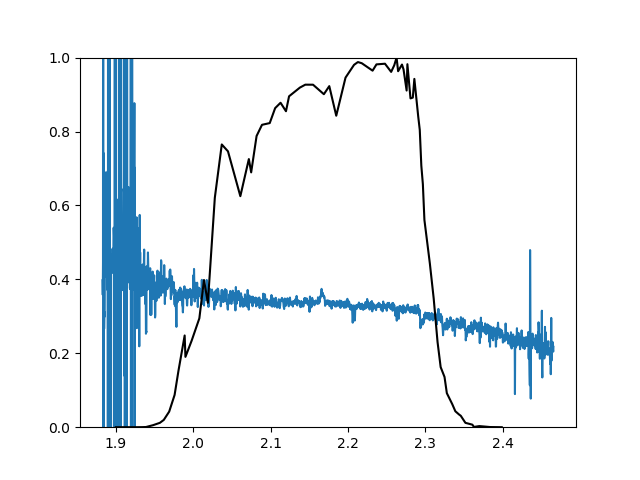

In [65]:
#AWI0005x3s_20171104 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20171104_python.txt','2017-11-04')

plt.figure()
plt.plot(AWI0005x3s_20171104.order3.wav, AWI0005x3s_20171104.order3.flux_watts/(2.0e-14))
#plt.ylim([0.,2.0e-14])
plt.ylim([0.,1.])

kresponsedf = pd.read_csv('kresponse.csv',low_memory=False)
kresponsedata = kresponsedf.values

kresponsewav = kresponsedata[:,0]
kresponseweight = kresponsedata[:,1]

kcombinedgrid = insort(kresponsewav, AWI0005x3s_20171104.order3.wav[2:-1])

plt.plot(kresponsewav, kresponseweight,'k')

plt.show()

[             nan              nan   7.95203000e-15 ...,   4.08960000e-15
   4.35063000e-15              nan]
1.88226 2.46585


<IPython.core.display.Javascript object>


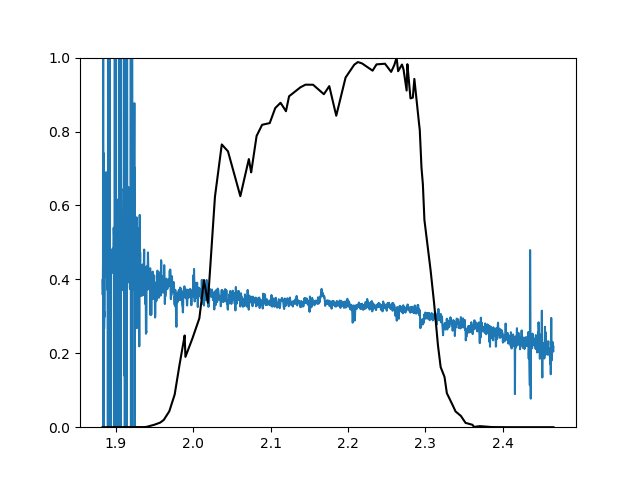

In [66]:
kresponseweight_combinedgrid = np.zeros(kcombinedgrid.size)
awi0005x3s_20171104_kband_combinedgrid = np.interp(kcombinedgrid, AWI0005x3s_20171104.order3.wav[2:-1], AWI0005x3s_20171104.order3.flux_watts[2:-1])

print AWI0005x3s_20171104.order3.flux_watts

for i in range(kcombinedgrid.size):
    if (kcombinedgrid[i] > AWI0005x3s_20171104.order3.wav[0]) and (kcombinedgrid[i] < AWI0005x3s_20171104.order3.wav[-2]):
        kresponseweight_combinedgrid[i] = np.interp(kcombinedgrid[i], kresponsewav, kresponseweight)

print AWI0005x3s_20171104.order3.wav[0], AWI0005x3s_20171104.order3.wav[-2]
plt.figure()
plt.plot(kcombinedgrid,awi0005x3s_20171104_kband_combinedgrid/(2.0e-14))
plt.plot(kcombinedgrid,kresponseweight_combinedgrid,'k')
plt.ylim([0.,1.])
plt.show()


In [68]:
kfilter_flux_numerator = np.trapz((awi0005x3s_20171104_kband_combinedgrid*kresponseweight_combinedgrid),x=kcombinedgrid)
kfilter_flux_denominator = np.trapz(kresponseweight_combinedgrid,x=kcombinedgrid)

print kfilter_flux_numerator
print kfilter_flux_denominator

kfilter_flux = kfilter_flux_numerator/kfilter_flux_denominator

print kfilter_flux

kmag_2mass  = 12.054

kflux_2mass = zpk*(10.**(-0.4*kmag_2mass))

print kflux_2mass

print kflux_2mass/kfilter_flux

1.74575802736e-15
0.261885268232
6.66611772075e-15
6.45874404894e-15
0.968891387687


[0.9560356412950837, 0.9668018122637443, 0.9872, 1.0, 1.0, 1.0]


<IPython.core.display.Javascript object>


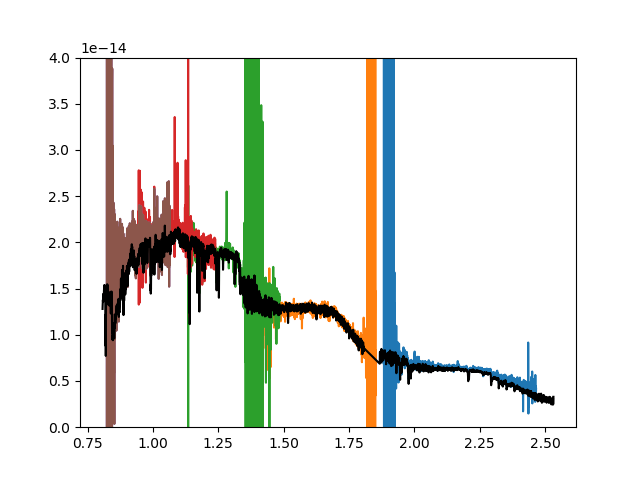

First row found: 47


In [79]:
weights = [(0.968891387687/1.01344693214), (1.01344693214/1.0482468271), 0.9872, 1., 1., 1.]

print weights

plt.figure()

ordercounter = 0

for i in range(6):
    plt.plot(AWI0005x3s_20171104.orderlist[i].wav, AWI0005x3s_20171104.orderlist[i].flux_watts*weights[i])

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')


plt.plot(template_spectrum.short_wavelength, template_spectrum.short_flux_density*0.00245,'k')

plt.ylim([0.,4.0e-14])
plt.show()

In [6]:
#HD74562_20171104_merged = import_arcoiris_from_text('HD74562_xtc_20171104_merged.txt','HD74562','2017-11-04')
HD74562_20171104_merged_revised = import_arcoiris_from_text('HD74562_xtc_comb_merged_revised.txt','HD74562','2017-11-04')
awi0005x3s_20171104_modVega_merged_noscaling = import_arcoiris_from_text('awi0005x3s_xtc_20171104_modVega_merged_noscaling.txt','AWI0005x3s_modVega','2017-11-04')
HD74562_20171104_raw_orders = import_arcoiris_spectrum_from_file('HD74562','HD74562_xtc_comb_python.txt','2017-11-04')


In [7]:
def cut_region_out(wav, flux, min_wav_cut, max_wav_cut):
    '''Removes a given region (usually a spectral line) from a spectrum'''
    
    wav_use = [wav[i] for i in range(len(wav)) if ((wav[i] < min_wav_cut) or (wav[i] > max_wav_cut))]
    flux_use = [flux[i] for i in range(len(wav)) if ((wav[i] < min_wav_cut) or (wav[i] > max_wav_cut))]
    
    return np.array(wav_use), np.array(flux_use)

<IPython.core.display.Javascript object>


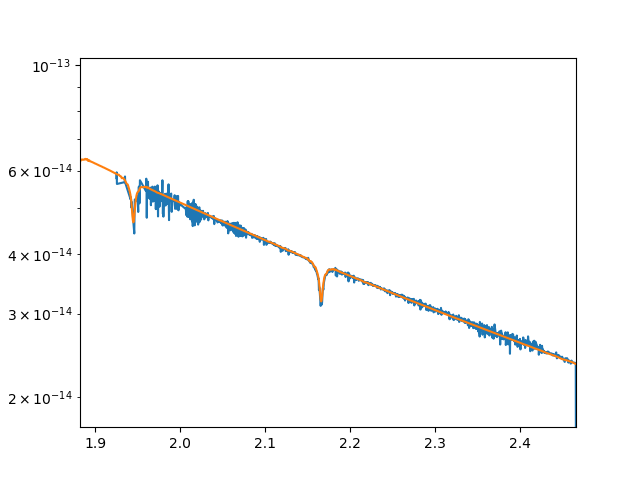

<IPython.core.display.Javascript object>


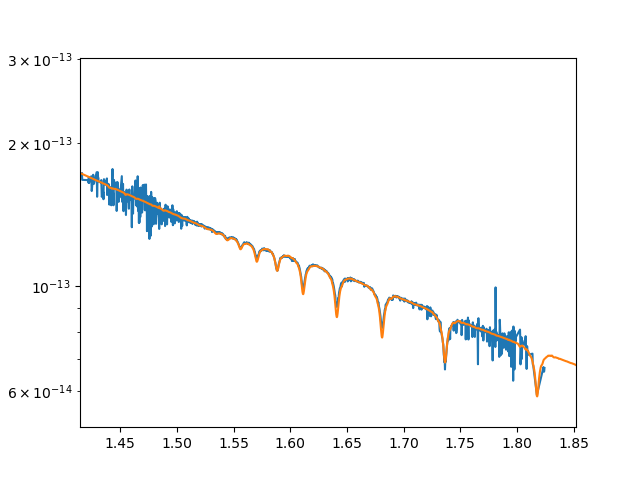

<IPython.core.display.Javascript object>


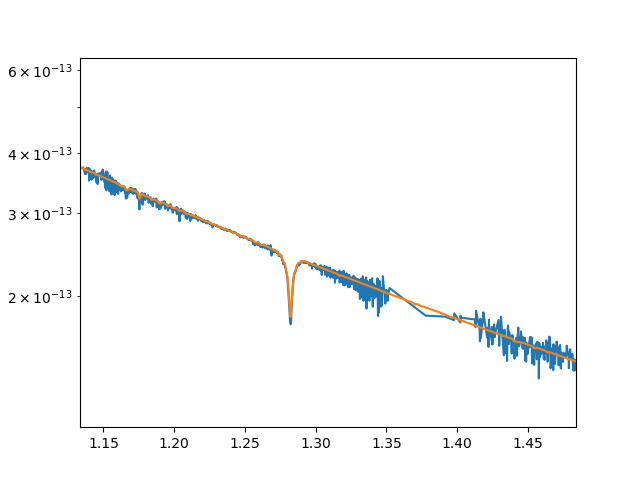

<IPython.core.display.Javascript object>


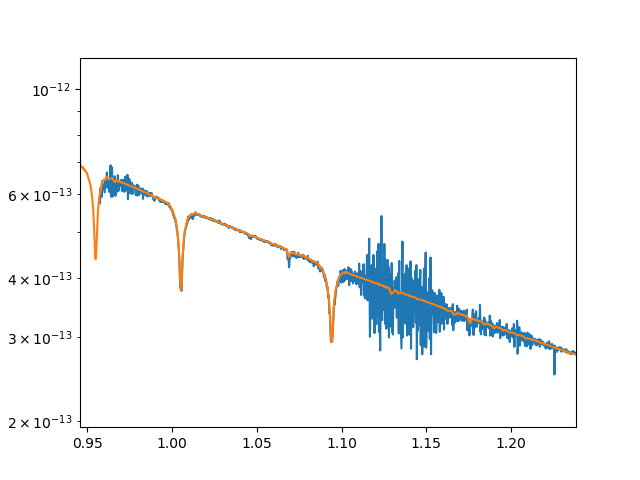

<IPython.core.display.Javascript object>


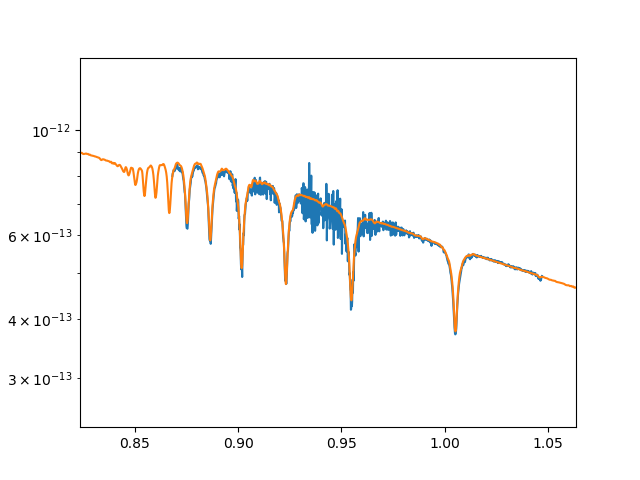

<IPython.core.display.Javascript object>


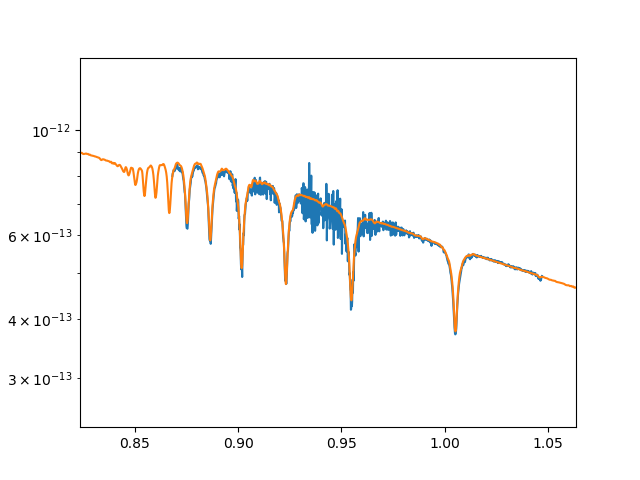

Order  3 : 0.983981693364
Order  4 : 1.0
Order  5 : 1.00686498856
Order  6 : 1.01830663616
Order  7 : 1.02974828375
Order  8 : 1.02974828375


In [8]:
f = np.array([0.86, 0.874, 0.88, 0.89, 0.9, 0.9])

ordercounter = 0

max_ordercounter = 6

for order in HD74562_20171104_raw_orders.orderlist:
    if ordercounter > max_ordercounter:
        break
    
    plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    flux_use = np.array([order.flux_ergs[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    
    plt.plot(wav_use, flux_use*f[ordercounter])
    plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    plt.xlim([min(order.wav), max(order.wav)])
    plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    plt.yscale("log",nonposy = 'clip')
    plt.show()
    
    ordercounter += 1
    
order_four_base = f[1]

f_scaled_to_order_four = f/order_four_base

#ordernamecounter = 3

for i in range(max_ordercounter):
    print "Order ", (i+3), ":", f_scaled_to_order_four[i]
    

<IPython.core.display.Javascript object>


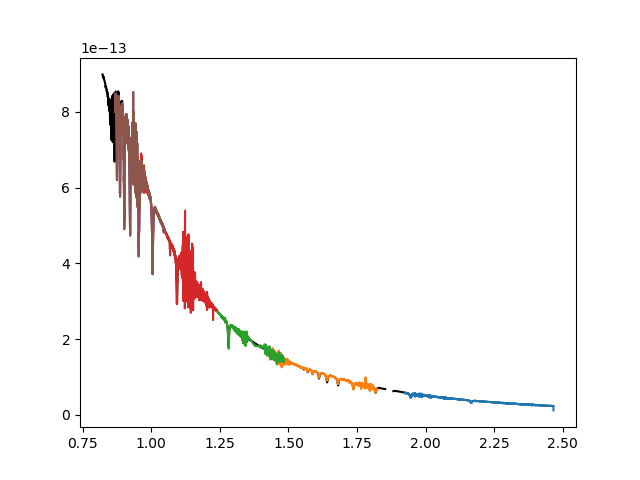

<IPython.core.display.Javascript object>


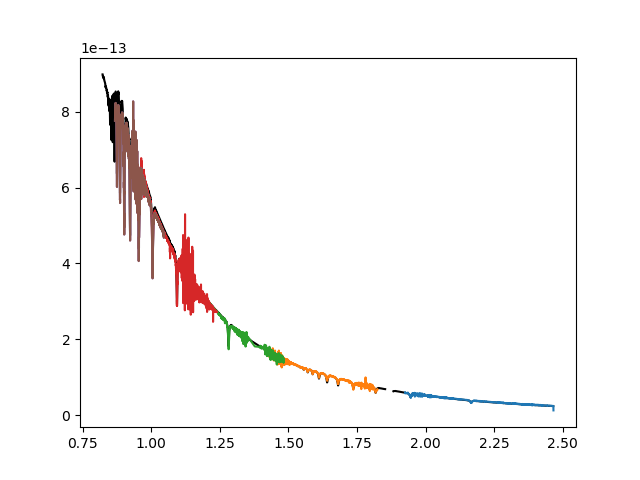

In [13]:
plt.figure()

plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux,'k')

ordercounter = 0

for order in HD74562_20171104_raw_orders.orderlist:
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    flux_use = np.array([order.flux_ergs[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    
    plt.plot(wav_use, flux_use*f[ordercounter])
    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    ordercounter += 1
plt.show()


plt.figure()

plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux,'k')

ordercounter = 0

for order in HD74562_20171104_raw_orders.orderlist:
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    flux_use = np.array([order.flux_ergs[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    
    plt.plot(wav_use, flux_use*f[1])#*f[ordercounter])
    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    ordercounter += 1
plt.show()

First row found: 47


<IPython.core.display.Javascript object>


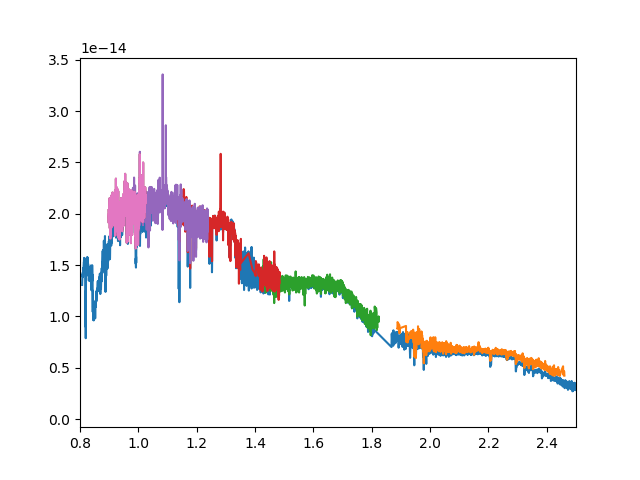

In [21]:
AWI0005x3s_20171104 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20171104_python.txt','2017-11-04')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

plt.figure()
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025)
         
ordercounter = 0

for order in AWI0005x3s_20171104.orderlist:
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use)#*f[1])#*f[ordercounter])
    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    ordercounter += 1
    
plt.xlim([0.8,2.5])
plt.show()




<IPython.core.display.Javascript object>


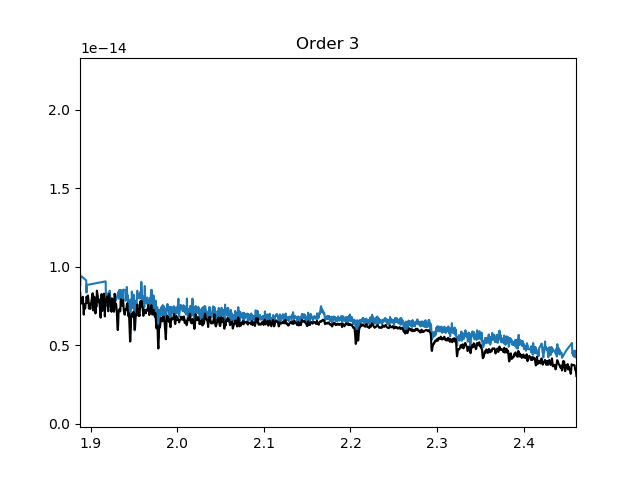

<IPython.core.display.Javascript object>


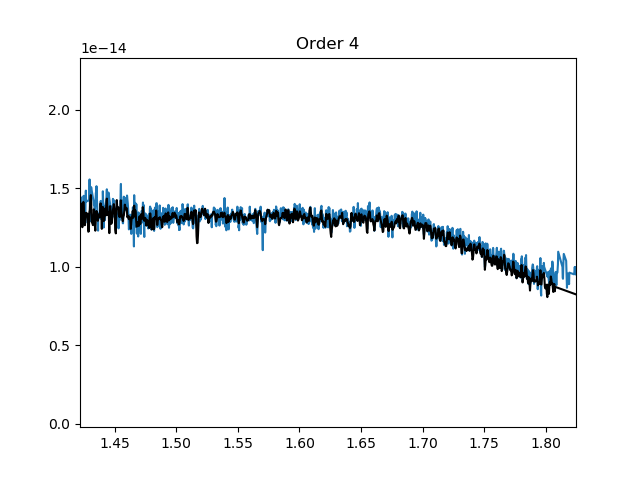

<IPython.core.display.Javascript object>


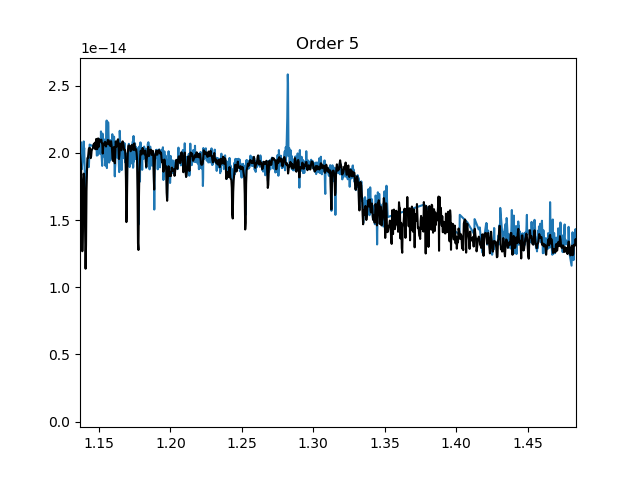

<IPython.core.display.Javascript object>


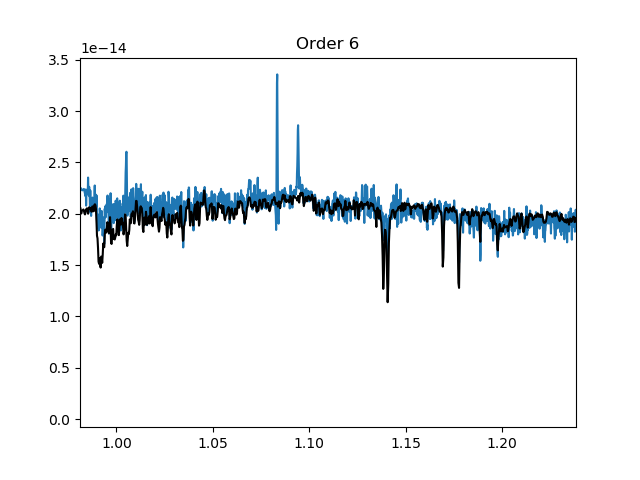

<IPython.core.display.Javascript object>


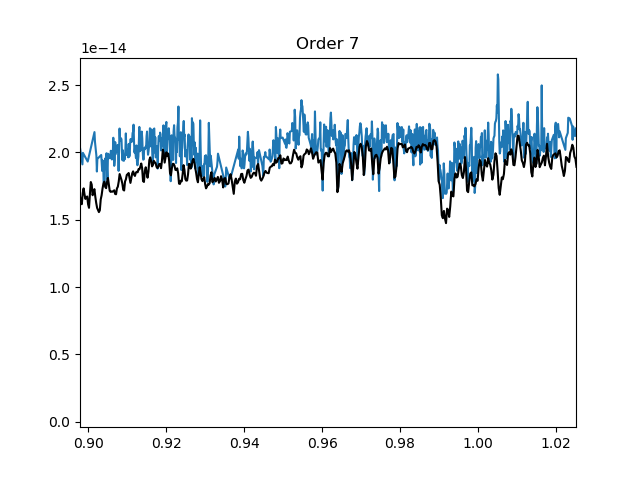

<IPython.core.display.Javascript object>


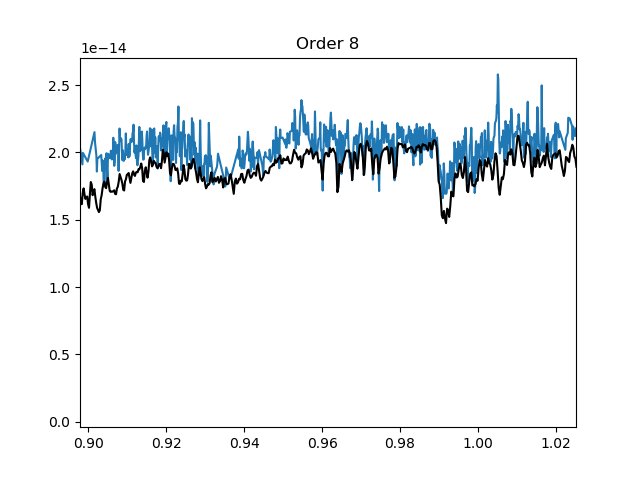

In [26]:
ordercounter = 0

for order in AWI0005x3s_20171104.orderlist:
    plt.figure()
    
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use)#*f[1])#*f[ordercounter])
    plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    plt.xlim([min(wav_use),max(wav_use)])
    plt.title('Order ' + str(ordercounter+3))
    plt.show()
    
    ordercounter += 1

3 0.983981693364


<IPython.core.display.Javascript object>


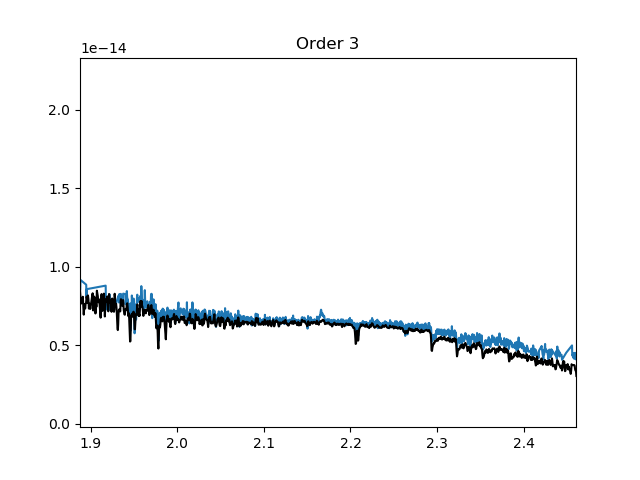

4 1.0


<IPython.core.display.Javascript object>


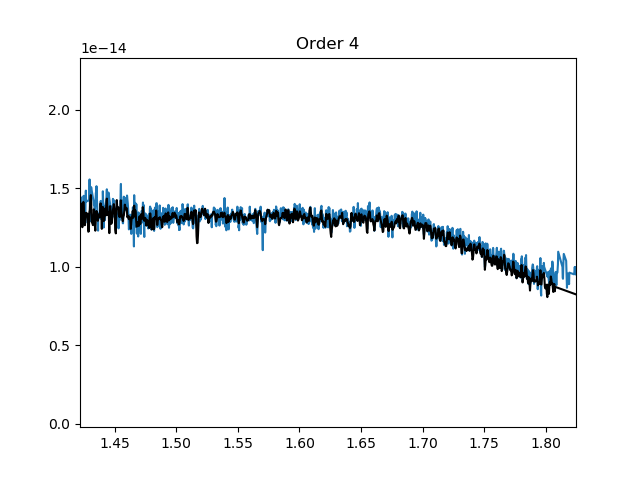

5 1.00686498856


<IPython.core.display.Javascript object>


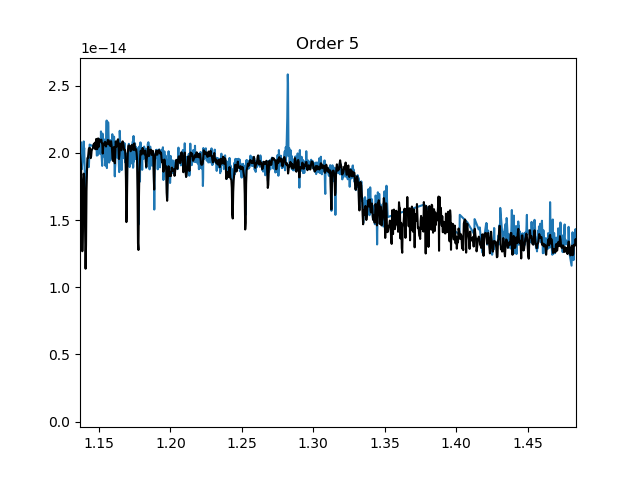

6 1.01830663616


<IPython.core.display.Javascript object>


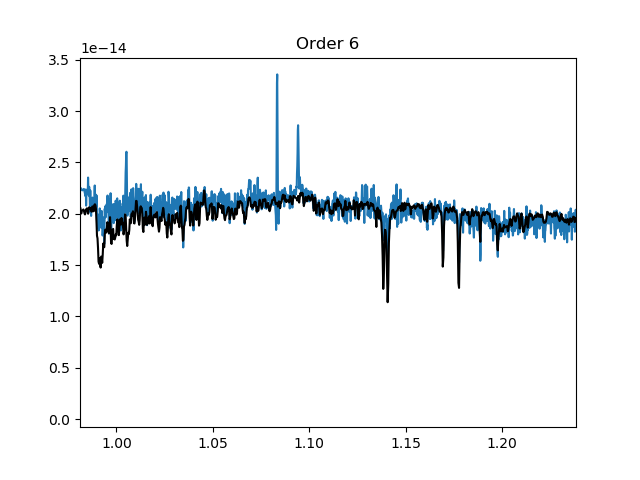

7 1.02974828375


<IPython.core.display.Javascript object>


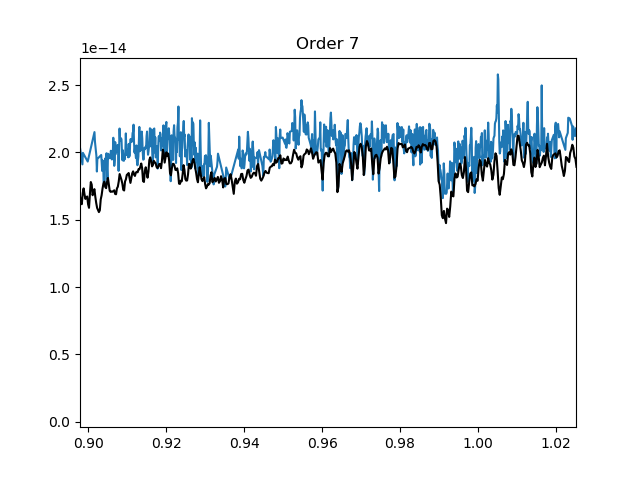

8 1.02974828375


<IPython.core.display.Javascript object>


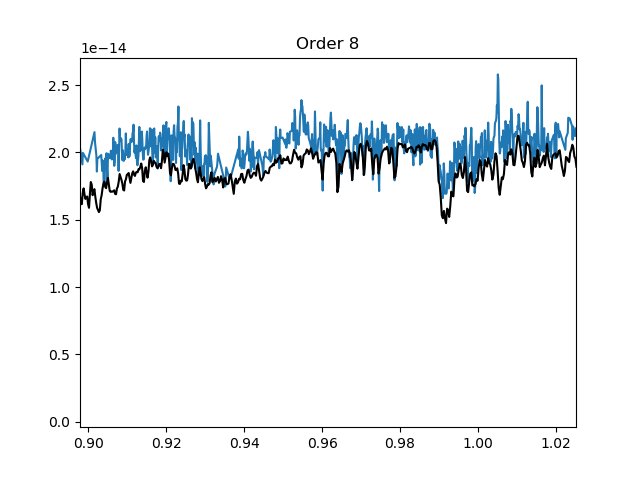

In [35]:
ordercounter = 0

#new_f = [f[i] for i in range(len(f))]


for order in AWI0005x3s_20171104.orderlist:
    print (ordercounter+3), f[ordercounter]/f[1]
    plt.figure()
    
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use*new_f[ordercounter])
    plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    plt.xlim([min(wav_use),max(wav_use)])
    plt.title('Order ' + str(ordercounter+3))
    plt.show()
    
    ordercounter += 1

<IPython.core.display.Javascript object>


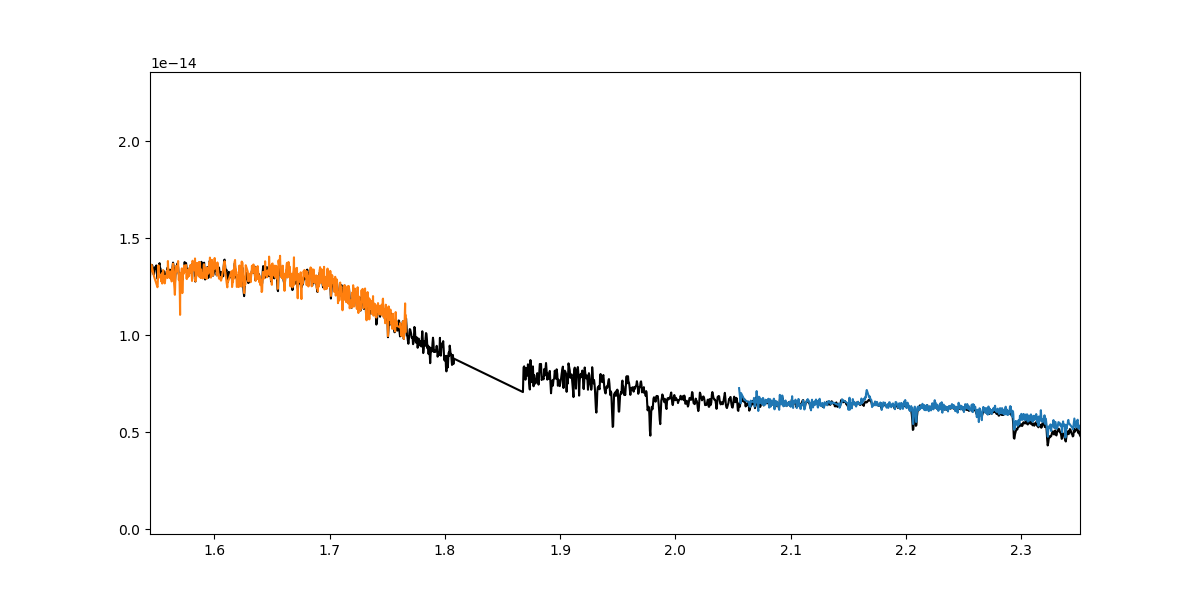

<IPython.core.display.Javascript object>


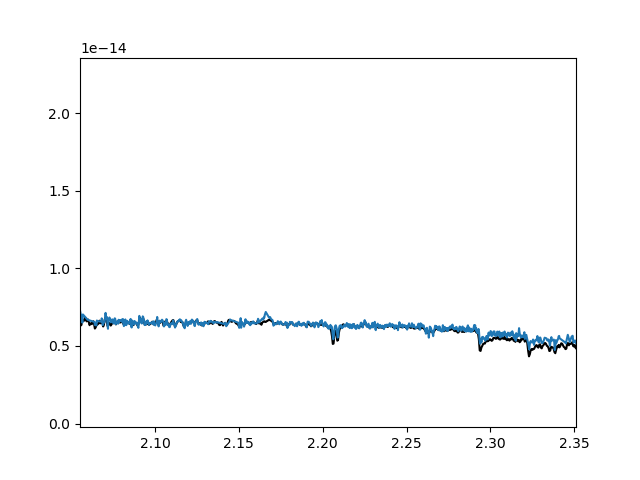

In [48]:
new_f _20180302= [0.96, 1., 1., 1., 1., 1.]

plt.figure(figsize=[12.,6.])

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.002525,'k')
wav_use_3 = np.array([AWI0005x3s_20171104.order3.wav[i] for i in range(AWI0005x3s_20171104.order3.wav.size) if order.snr[i] > 20.])
flux_use_3 = np.array([AWI0005x3s_20171104.order3.flux_watts[i] for i in range(AWI0005x3s_20171104.order3.wav.size) if order.snr[i] > 20.])
wav_use_4 = np.array([AWI0005x3s_20171104.order4.wav[i] for i in range(AWI0005x3s_20171104.order4.wav.size) if order.snr[i] > 20.])
flux_use_4 = np.array([AWI0005x3s_20171104.order4.flux_watts[i] for i in range(AWI0005x3s_20171104.order4.wav.size) if order.snr[i] > 20.])

plt.plot(wav_use_3, flux_use_3 * new_f[0])
plt.plot(wav_use_4, flux_use_4 * new_f[1])

plt.xlim([min(wav_use_4), max(wav_use_3)])

plt.show()

plt.figure()

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.002525,'k')
plt.plot(wav_use_3, flux_use_3 * new_f[0])
plt.xlim([min(wav_use_3), max(wav_use_3)])
plt.show()


<IPython.core.display.Javascript object>


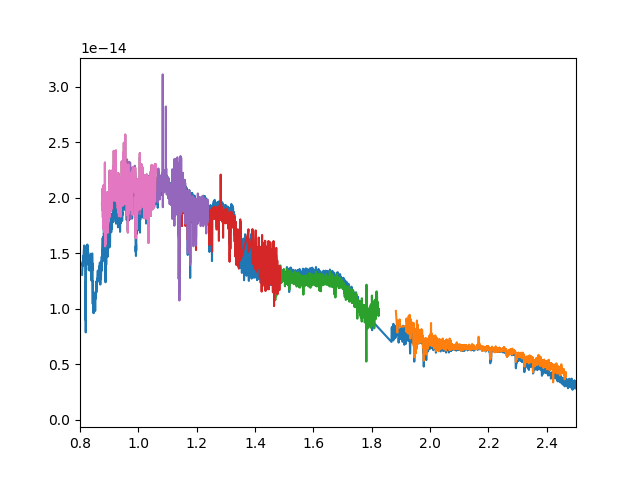

In [49]:
AWI0005x3s_20180302 = import_arcoiris_spectrum_from_file('AWI0005x3s','awi0005x3s_xtc_20180302_python.txt','2018-03-02')

plt.figure()
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025)
         
ordercounter = 0

for order in AWI0005x3s_20180302.orderlist:
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use)#*f[1])#*f[ordercounter])
    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    ordercounter += 1
    
plt.xlim([0.8,2.5])
plt.show()



<IPython.core.display.Javascript object>


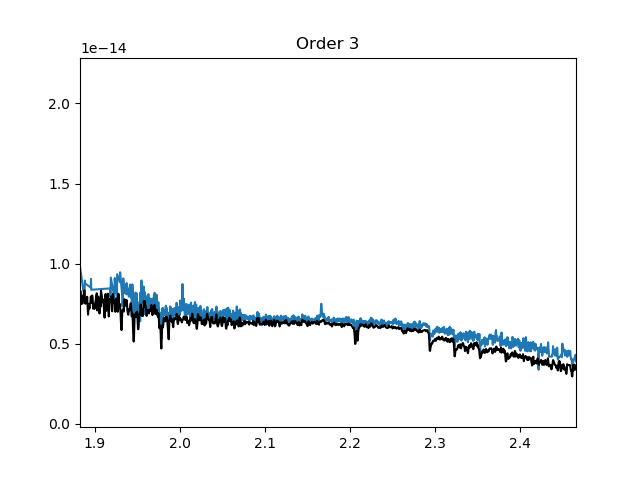

<IPython.core.display.Javascript object>


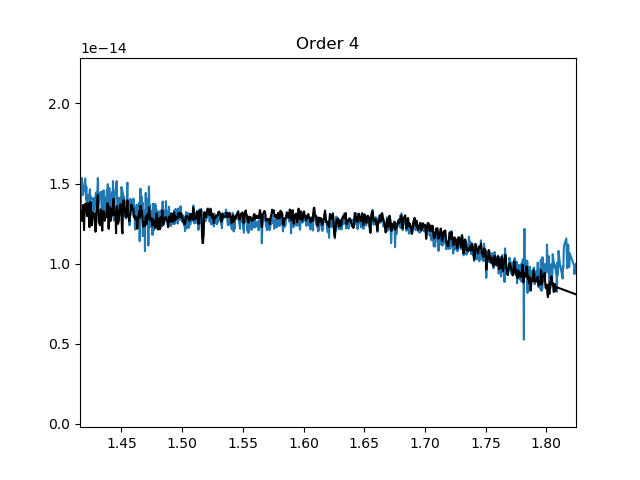

<IPython.core.display.Javascript object>


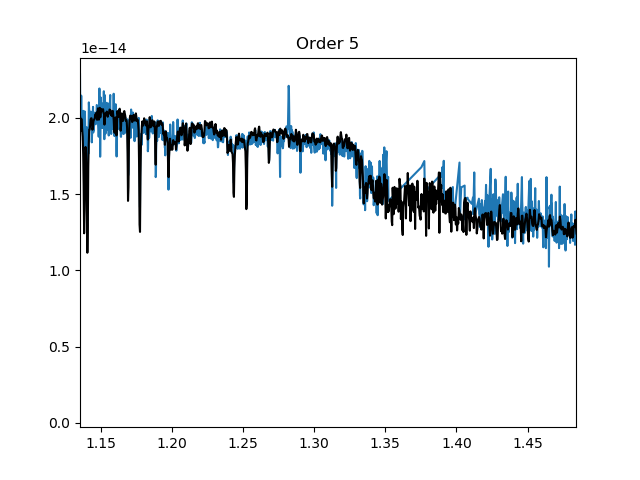

<IPython.core.display.Javascript object>


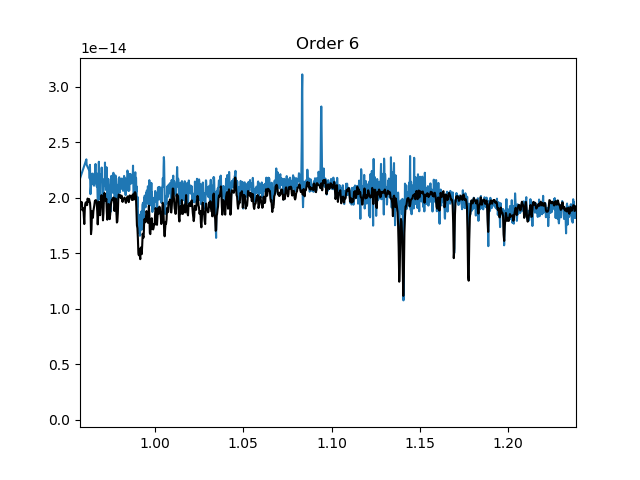

<IPython.core.display.Javascript object>


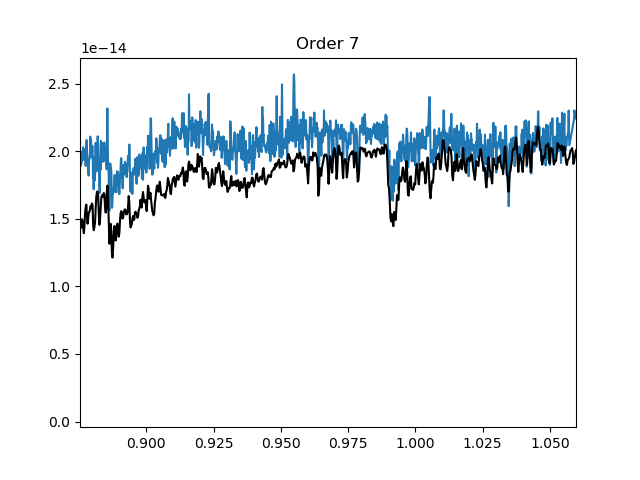

<IPython.core.display.Javascript object>


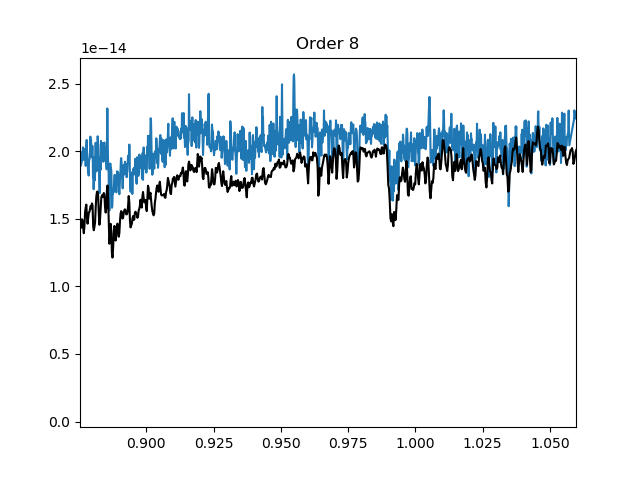

In [51]:
ordercounter = 0

for order in AWI0005x3s_20180302.orderlist:
    plt.figure()
    
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use)#*f[1])#*f[ordercounter])
    plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    plt.xlim([min(wav_use),max(wav_use)])
    plt.title('Order ' + str(ordercounter+3))
    plt.show()
    
    ordercounter += 1

<IPython.core.display.Javascript object>


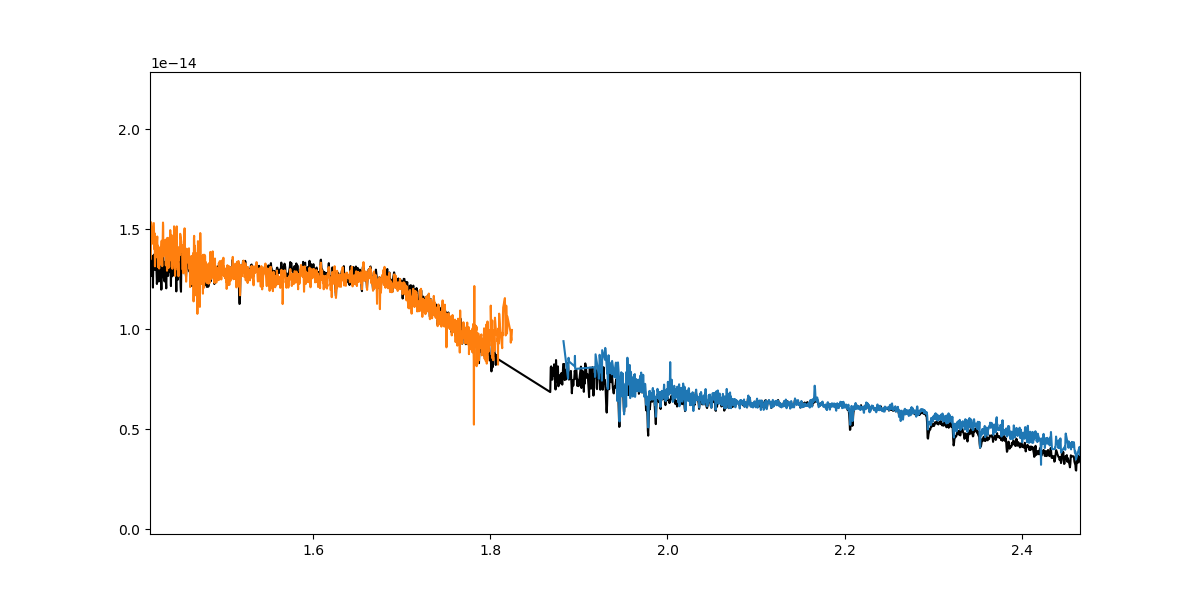

<IPython.core.display.Javascript object>


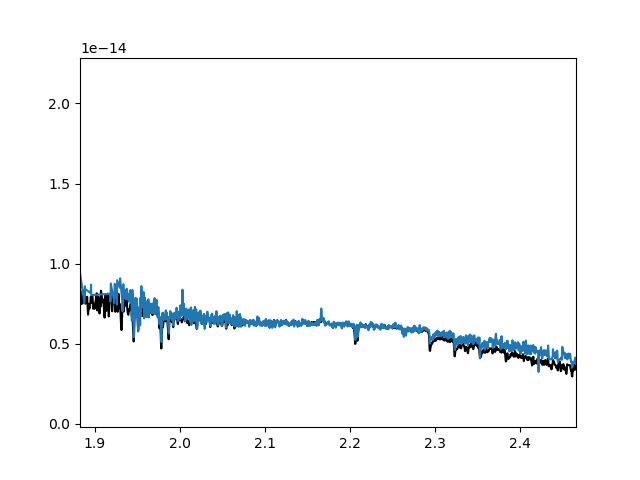

In [58]:
new_f_20180302= [0.96, 1., 1., 1., 1., 1.]

plt.figure(figsize=[12.,6.])

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')
wav_use_3 = np.array([AWI0005x3s_20180302.order3.wav[i] for i in range(AWI0005x3s_20180302.order3.wav.size) if AWI0005x3s_20180302.order3.snr[i] > 20.])
flux_use_3 = np.array([AWI0005x3s_20180302.order3.flux_watts[i] for i in range(AWI0005x3s_20180302.order3.wav.size) if AWI0005x3s_20180302.order3.snr[i] > 20.])
wav_use_4 = np.array([AWI0005x3s_20180302.order4.wav[i] for i in range(AWI0005x3s_20180302.order4.wav.size) if AWI0005x3s_20180302.order4.snr[i] > 20.])
flux_use_4 = np.array([AWI0005x3s_20180302.order4.flux_watts[i] for i in range(AWI0005x3s_20180302.order4.wav.size) if AWI0005x3s_20180302.order4.snr[i] > 20.])

plt.plot(wav_use_3, flux_use_3 * new_f[0])
plt.plot(wav_use_4, flux_use_4 * new_f[1])

plt.xlim([min(wav_use_4), max(wav_use_3)])

plt.show()

plt.figure()

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')
plt.plot(wav_use_3, flux_use_3 * new_f_20180302[0])
plt.xlim([min(wav_use_3), max(wav_use_3)])
plt.show()


<IPython.core.display.Javascript object>


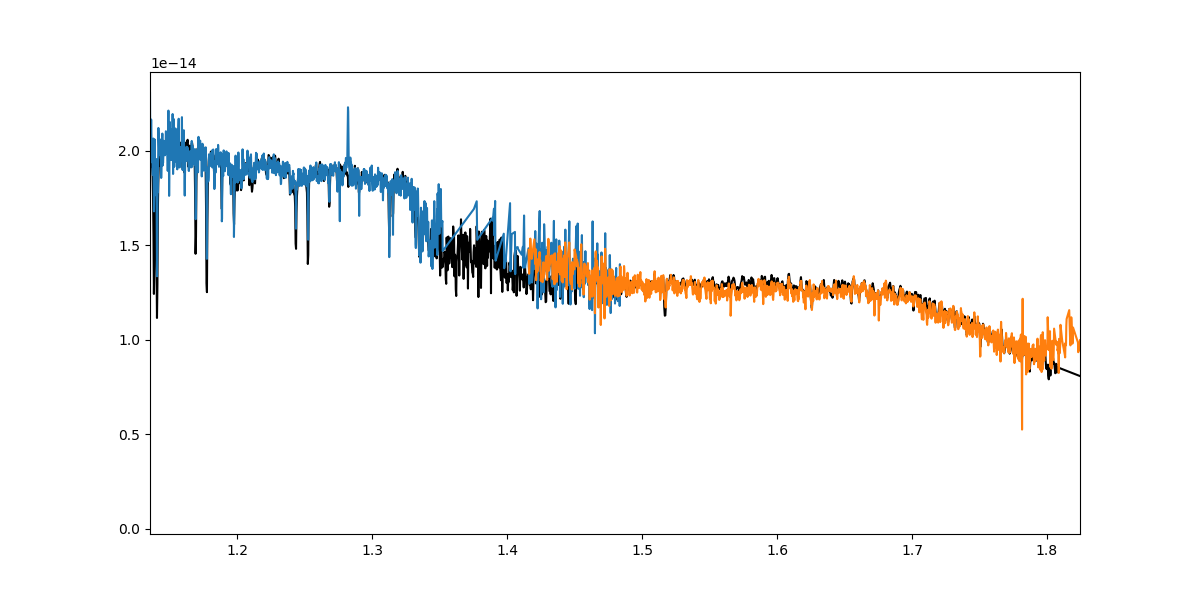

<IPython.core.display.Javascript object>


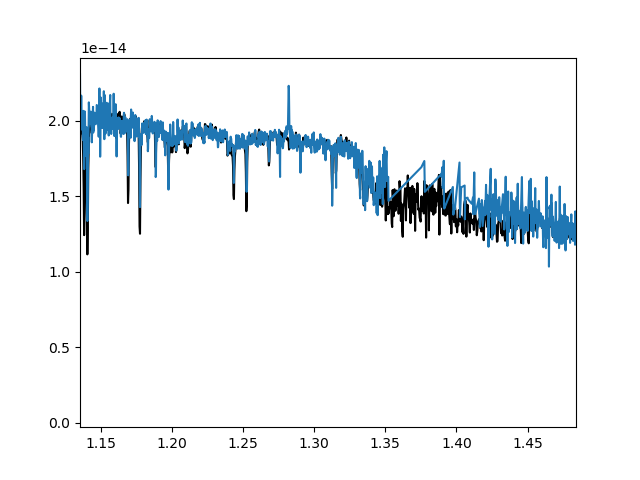

In [63]:
new_f_20180302= [0.96, 1., 1.01, 1., 1., 1.]

plt.figure(figsize=[12.,6.])

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')
wav_use_5 = np.array([AWI0005x3s_20180302.order5.wav[i] for i in range(AWI0005x3s_20180302.order5.wav.size) if AWI0005x3s_20180302.order5.snr[i] > 20.])
flux_use_5 = np.array([AWI0005x3s_20180302.order5.flux_watts[i] for i in range(AWI0005x3s_20180302.order5.wav.size) if AWI0005x3s_20180302.order5.snr[i] > 20.])
wav_use_4 = np.array([AWI0005x3s_20180302.order4.wav[i] for i in range(AWI0005x3s_20180302.order4.wav.size) if AWI0005x3s_20180302.order4.snr[i] > 20.])
flux_use_4 = np.array([AWI0005x3s_20180302.order4.flux_watts[i] for i in range(AWI0005x3s_20180302.order4.wav.size) if AWI0005x3s_20180302.order4.snr[i] > 20.])

plt.plot(wav_use_5, flux_use_5 * new_f_20180302[2])
plt.plot(wav_use_4, flux_use_4 * new_f_20180302[1])

plt.xlim([min(wav_use_5), max(wav_use_4)])

plt.show()

plt.figure()

plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')
plt.plot(wav_use_5, flux_use_5 * new_f_20180302[2])
plt.xlim([min(wav_use_5), max(wav_use_5)])
plt.show()


3 0.983981693364


<IPython.core.display.Javascript object>


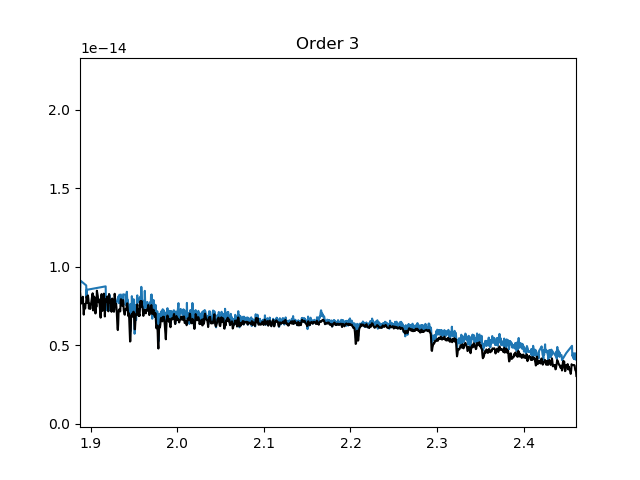

4 1.0


<IPython.core.display.Javascript object>


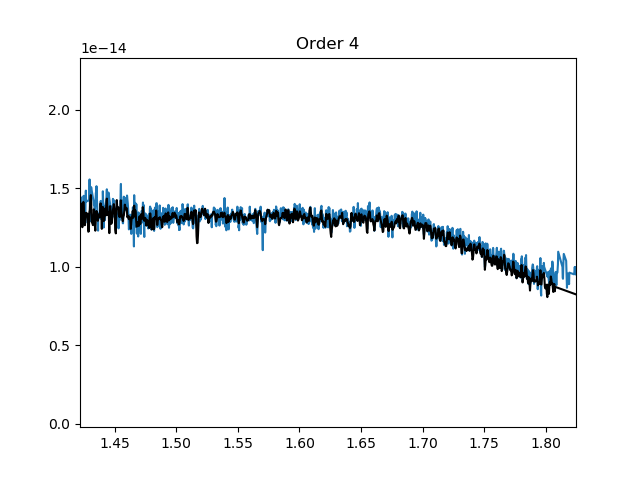

5 1.00686498856


<IPython.core.display.Javascript object>


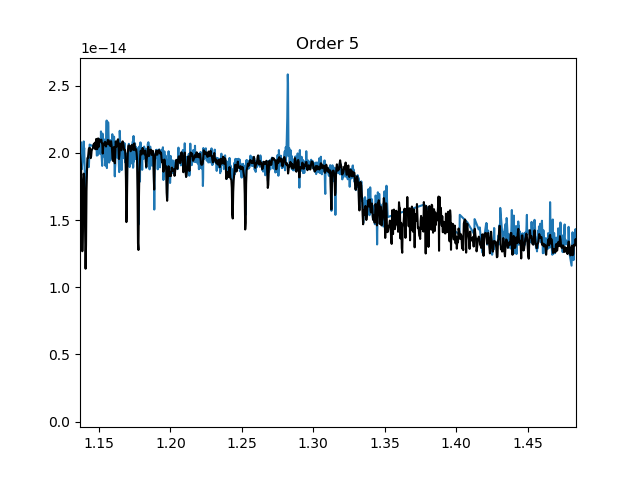

6 1.01830663616


<IPython.core.display.Javascript object>


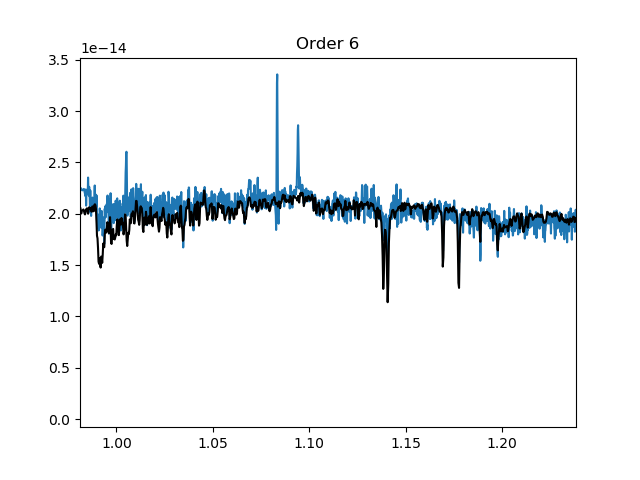

7 1.02974828375


<IPython.core.display.Javascript object>


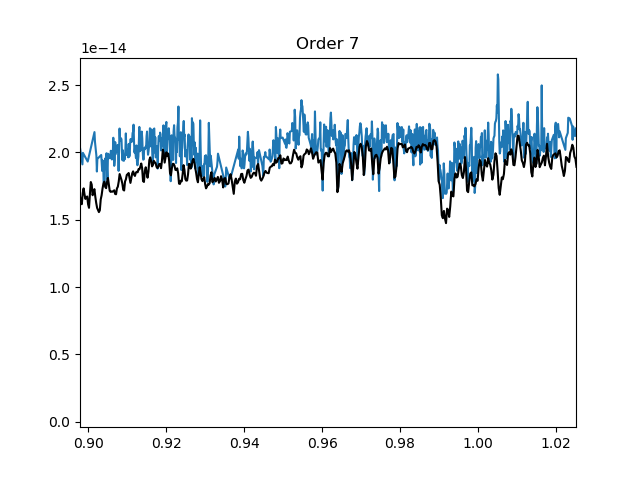

8 1.02974828375


<IPython.core.display.Javascript object>


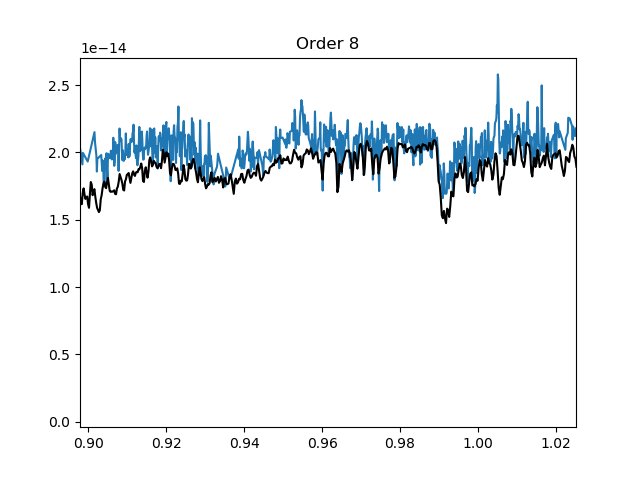

In [47]:
ordercounter = 0

#new_f = [f[i] for i in range(len(f))]


for order in AWI0005x3s_20171104.orderlist:
    print (ordercounter+3), f[ordercounter]/f[1]
    plt.figure()
    
    if ordercounter > max_ordercounter:
        break
    
    #plt.figure()
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    flux_use = np.array([order.flux_watts[i] for i in range(order.wav.size) if order.snr[i] > 20.])
    
    plt.plot(wav_use, flux_use*new_f[ordercounter])
    plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')    #plt.plot(awi0005x3s_20171104_modVega_merged_noscaling.wav, awi0005x3s_20171104_modVega_merged_noscaling.flux)
    #plt.xlim([min(order.wav), max(order.wav)])
    #plt.ylim([0.25*max(flux_use), 1.5*(max(flux_use))])
    #plt.yscale("log",nonposy = 'clip')
    #plt.show()
    
    plt.xlim([min(wav_use),max(wav_use)])
    plt.title('Order ' + str(ordercounter+3))
    plt.show()
    
    ordercounter += 1

<IPython.core.display.Javascript object>


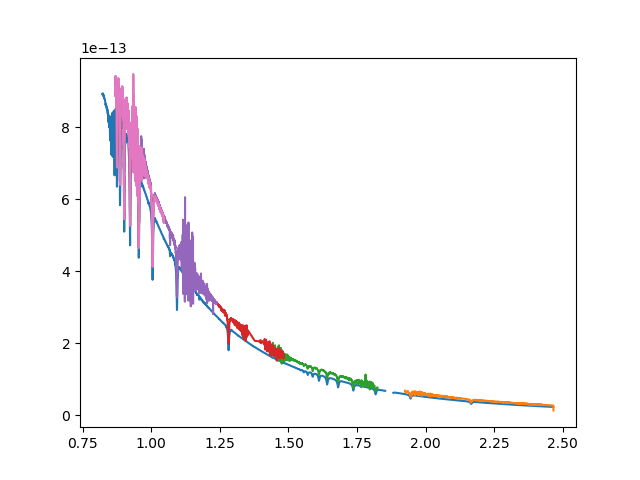

1703
1703
Min found
Max found
9000.0 0.1


<IPython.core.display.Javascript object>


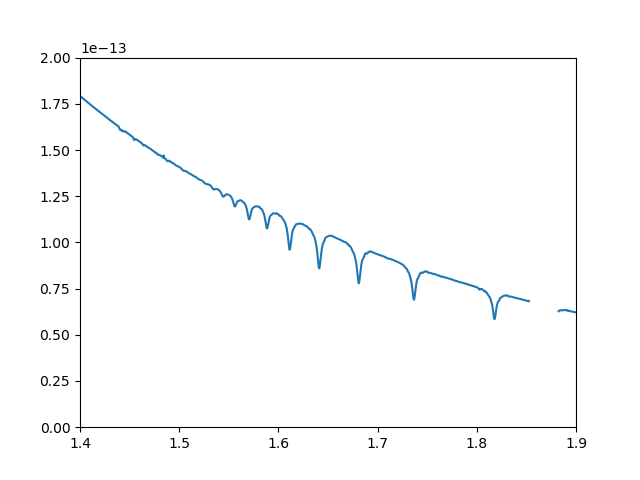

<IPython.core.display.Javascript object>


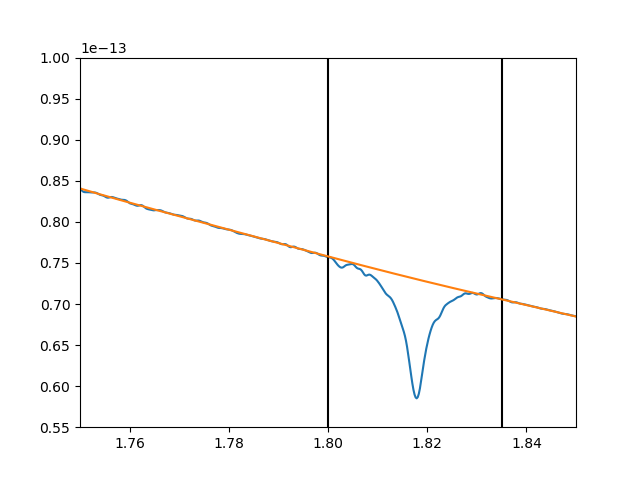

[ 1.75    1.7525  1.755   1.7575  1.76    1.7625  1.765   1.7675  1.77
  1.7725  1.775   1.7775  1.78    1.7825  1.785   1.7875  1.79    1.84
  1.8425  1.845   1.8475  1.85  ]


<IPython.core.display.Javascript object>


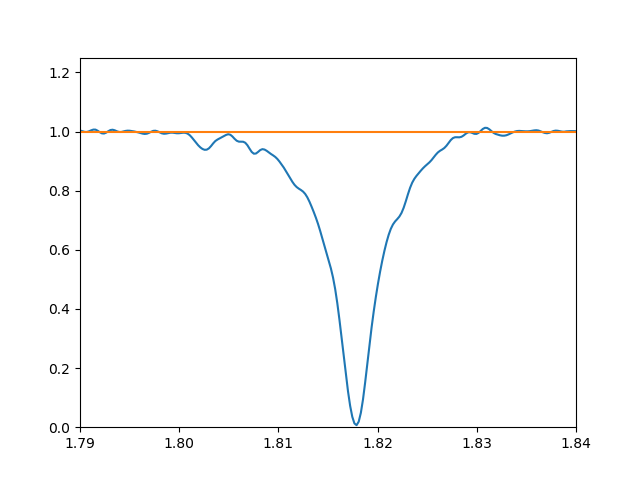

<IPython.core.display.Javascript object>


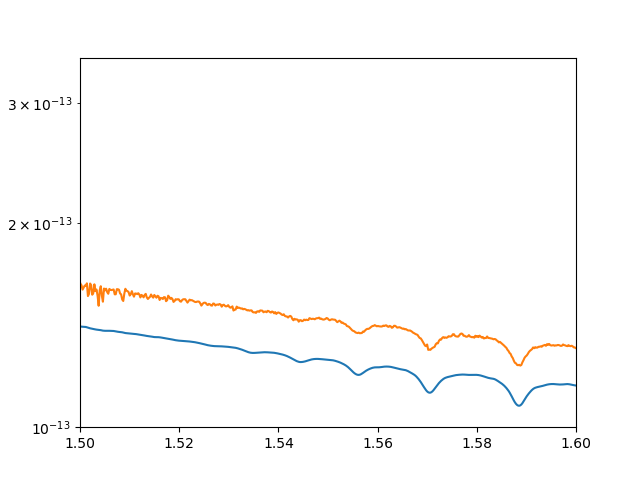

<IPython.core.display.Javascript object>


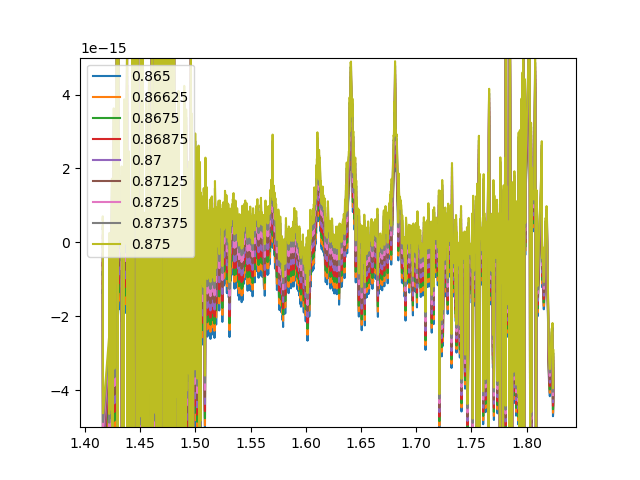

val: 0.865 avg: -7.50077483273e-16
val: 0.86625 avg: -5.97522028753e-16
val: 0.8675 avg: -4.44966574234e-16
val: 0.86875 avg: -2.92411119714e-16
val: 0.87 avg: -1.39855665194e-16
val: 0.87125 avg: 1.26997893254e-17
val: 0.8725 avg: 1.65255243845e-16
val: 0.87375 avg: 3.17810698365e-16
val: 0.875 avg: 4.70366152885e-16


In [45]:
plt.figure()

ordercounter = 0

#f_values = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]

plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)

for order in HD74562_20171104_raw_orders.orderlist:
    wav_use = np.array([order.wav[i] for i in range(order.wav.size) if order.snr[i] > 200.])
    flux_use = np.array([order.flux_ergs[i] for i in range(order.wav.size) if order.snr[i] > 200])
    plt.plot(wav_use, flux_use)
    
    ordercounter += 1

plt.show()    

possible_vals = np.linspace(0.865,0.875,9)
#val = 0.872

#fig1 = plt.figure()
#fig2 = plt.figure()

#ax = fig1.add_subplot(111)
#ax1 = fig2.add_subplot(111)

wav_use = np.array([HD74562_20171104_raw_orders.order4.wav[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])
flux_use = np.array([HD74562_20171104_raw_orders.order4.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])

print wav_use.size
print flux_use.size

min_found = False
max_found = False

min_index = None
max_index = None

for i in range(awi0005x3s_20171104_modVega_merged.wav.size):
    if not min_found and awi0005x3s_20171104_modVega_merged.wav[i] > min(wav_use):
        print "Min found"
        min_index = i-1
        min_found = True
    if not max_found and awi0005x3s_20171104_modVega_merged.wav[i] > max(wav_use):
        max_index = i-1
        print "Max found"
        max_found = True
    if (min_index) and (max_index):
        break

combined_order_grid = insort(awi0005x3s_20171104_modVega_merged.wav[min_index:(max_index+1)],wav_use)


def find_best_fit_blackbody(theta, wavelength, flux, flux_err):
    log10Teff, log10rdstar = theta
    
    wavelength_angstroms = wavelength*10000.* u.AA
    
    Teff = (10.**log10Teff) * u.K
    rdstar = (10.**log10rdstar)
    
    blackbody_flux_temp = blackbody_lambda(wavelength_angstroms, Teff) * np.pi * u.sr
    blackbody_flux = blackbody_flux_temp * u.cm * u.cm * u.s / u.erg * wavelength_angstroms / wavelength
    
    model = blackbody_flux * (rdstar**2)
    
    inv_sigma2 = 1./(flux_err**2)
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
nll = lambda *args: -find_best_fit_blackbody(*args)

result = minimize(nll, [np.log10(9000.), (-1.)], args = (HD74562_20171104_merged_revised.wav, HD74562_20171104_merged_revised.flux, HD74562_20171104_merged_revised.err))
    
log10Teffopt, log10rdstaropt = result["x"]
print 10.**log10Teffopt, 10.**log10rdstaropt

result_blackbody = blackbody_lambda(HD74562_20171104_merged_revised.wav * 10000.*u.AA, 9700.) * np.pi * u.sr * u.cm * u.cm * u.s / u.erg * u.AA * (4.9e-20)
    
plt.figure()
plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)
#plt.plot(wav_use, flux_use)
#plt.plot(HD74562_20171104_merged_revised.wav, result_blackbody)
plt.xlim([1.4,1.9])
plt.ylim([0.0e-13,2.0e-13])
plt.plot()


plt.figure()
plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)
xboundlow = 1.835
xboundhigh = 1.80

testline_low_x = np.linspace(1.75,1.79,17)
testline_high_x = np.linspace(1.84,1.85,5)

testline_x = np.concatenate((testline_low_x, testline_high_x))
print testline_x

testline_y = np.interp(testline_x, awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)

#from scipy.stats import linregress
#slope, intercept, rvalue, pvalue, stderr = linregress(testline_x, testline_y)

coefficients = np.polyfit(testline_x, testline_y, 5)
p = np.poly1d(coefficients)

line_overlay_use = p(awi0005x3s_20171104_modVega_merged.wav)

plt.plot([xboundlow,xboundlow],[0.,1.],'k')
plt.plot([xboundhigh,xboundhigh],[0.,1.],'k')
#plt.plot(testline_x, testline_y)
plt.plot(awi0005x3s_20171104_modVega_merged.wav, line_overlay_use)
plt.xlim([1.75,1.85])
plt.ylim([0.55e-13,1.0e-13])
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_modVega_merged.wav, ((awi0005x3s_20171104_modVega_merged.flux/line_overlay_use)-0.8)*5.)
plt.plot([1.75,1.85],[1.,1.])
plt.xlim([1.79,1.84])
plt.ylim([0.0,1.25])
plt.show()

plt.figure()
plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux, label=str(val))

#for val in possible_vals:
    #flux_use = np.array([HD74562_20171104_raw_orders.order4.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order3.snr[i] > 200.)])*val
#plt.plot(HD74562_20171104_merged_revised.wav, HD74562_20171104_merged_revised.flux)
    #plt.plot(wav_use, flux_use, label=str(val))
    
#flux_use = np.array([HD74562_20171104_raw_orders.order4.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])

#print wav_use.size


plt.plot(wav_use, flux_use)
    
plt.xlim([1.5, 1.6])
plt.ylim([1.0e-13,3.5e-13])
plt.yscale('log',nonposy="clip")
plt.show()

grid_use = np.array([x for x in combined_order_grid if (x > 1.51) and (x < 1.75)])

plt.figure()

for val in possible_vals:
    flux_use = np.array([HD74562_20171104_raw_orders.order4.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])*val
    awi0005x3s_order_interp_flux = np.interp(combined_order_grid, awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)
    flux_use_interp = np.interp(combined_order_grid, wav_use, flux_use)

    plt.plot(combined_order_grid, flux_use_interp - awi0005x3s_order_interp_flux,label=str(val))
    
    vals_used_in_average = np.interp(grid_use, combined_order_grid, (flux_use_interp - awi0005x3s_order_interp_flux))
    
    print "val:", val, "avg:", np.sum(vals_used_in_average)/vals_used_in_average.size


    
plt.legend(loc='upper left')
plt.ylim([-5.0e-15,5.0e-15])
plt.show()

<IPython.core.display.Javascript object>


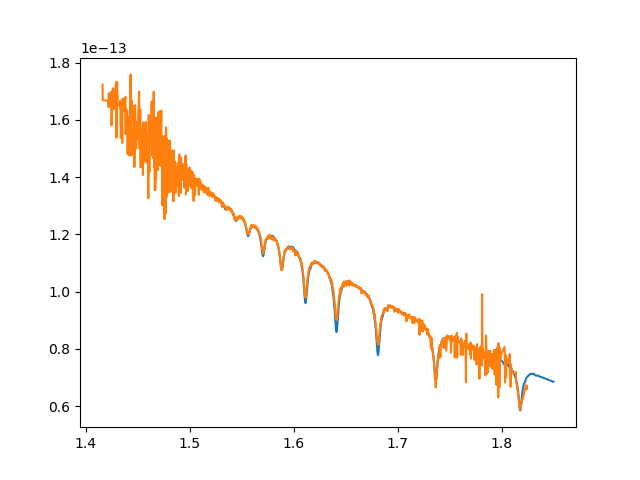

<IPython.core.display.Javascript object>


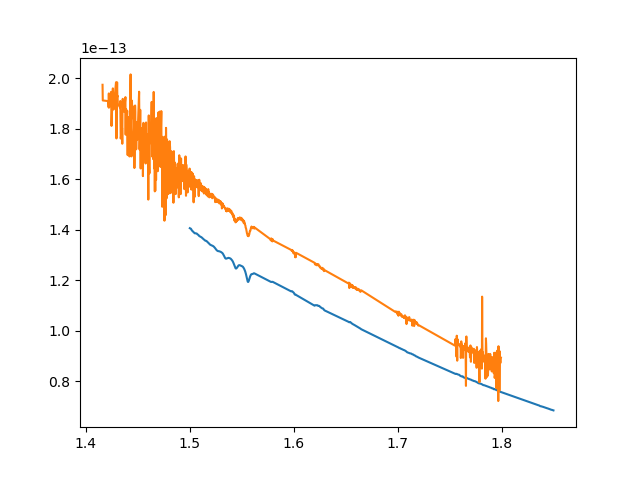

<IPython.core.display.Javascript object>


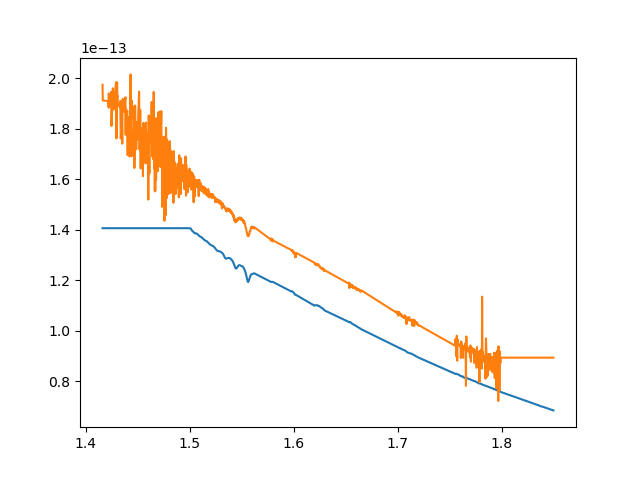

<IPython.core.display.Javascript object>


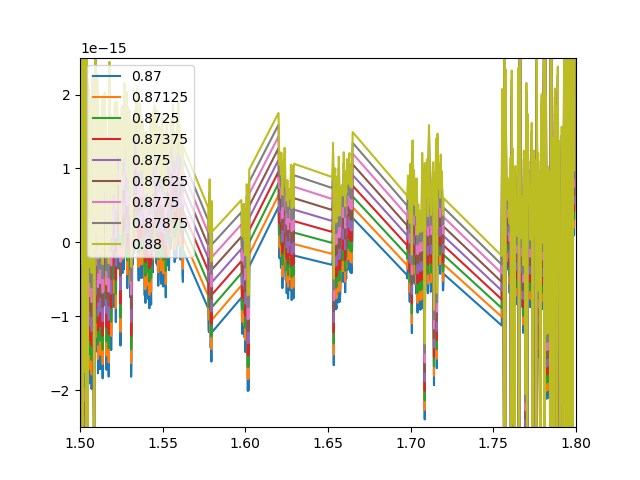

val: 0.87 avg: 1.39180428601e-15
val: 0.87125 avg: 1.55257950424e-15
val: 0.8725 avg: 1.71335472247e-15
val: 0.87375 avg: 1.8741299407e-15
val: 0.875 avg: 2.03490515892e-15
val: 0.87625 avg: 2.19568037715e-15
val: 0.8775 avg: 2.35645559538e-15
val: 0.87875 avg: 2.51723081361e-15
val: 0.88 avg: 2.67800603184e-15


In [67]:
vega_order4_wav = [awi0005x3s_20171104_modVega_merged.wav[i] for i in range(awi0005x3s_20171104_modVega_merged.wav.size) if ((awi0005x3s_20171104_modVega_merged.wav[i] > 1.5) and (awi0005x3s_20171104_modVega_merged.wav[i] < 1.85))]
vega_order4_flux = [awi0005x3s_20171104_modVega_merged.flux[i] for i in range(awi0005x3s_20171104_modVega_merged.wav.size) if ((awi0005x3s_20171104_modVega_merged.wav[i] > 1.5) and (awi0005x3s_20171104_modVega_merged.wav[i] < 1.85))]

line_regions_list = [(1.8, 1.835), (1.72, 1.755), (1.665, 1.6975), (1.63, 1.6525), (1.6025, 1.62), (1.58, 1.5975), (1.5625, 1.5775)]

vega_order4_wav_use = np.array(vega_order4_wav)
vega_order4_flux_use = np.array(vega_order4_flux)

wav_use = np.array([HD74562_20171104_raw_orders.order4.wav[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])
flux_use = np.array([HD74562_20171104_raw_orders.order4.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order4.wav.size) if (HD74562_20171104_raw_orders.order4.snr[i] > 200.)])


possible_vals = np.linspace(0.87, 0.88, 9)

plt.figure()
plt.plot(vega_order4_wav_use, vega_order4_flux_use)
plt.plot(wav_use, flux_use*0.8725)
plt.show()

for bounds in line_regions_list:
    lowbound, highbound = bounds
    vega_order4_wav_use, vega_order4_flux_use = cut_region_out(vega_order4_wav_use, vega_order4_flux_use, lowbound, highbound)
    wav_use, flux_use = cut_region_out(wav_use, flux_use, lowbound, highbound)    
    
    
plt.figure()
plt.plot(vega_order4_wav_use, vega_order4_flux_use)
plt.plot(wav_use, flux_use)
plt.show()

combined_grid_after_line_removal = insort(vega_order4_wav_use, wav_use)

vega_after_line_removal = np.interp(combined_grid_after_line_removal, vega_order4_wav_use, vega_order4_flux_use)
HD74562_after_line_removal = np.interp(combined_grid_after_line_removal, wav_use, flux_use)

plt.figure()
plt.plot(combined_grid_after_line_removal, vega_after_line_removal)
plt.plot(combined_grid_after_line_removal, HD74562_after_line_removal)
plt.show()

plt.figure()

for val in possible_vals:
    HD74562_scaled = HD74562_after_line_removal * val
    
    #print combined_grid_after_line_removal.size
    #print HD74562_scaled.size
    #print vega_after_line_removal.size

    plt.plot(combined_grid_after_line_removal, HD74562_scaled - vega_after_line_removal,label=str(val))
    
    #vals_used_in_average = np.interp(grid_use, combined_order_grid, (flux_use_interp - awi0005x3s_order_interp_flux))
    
    print "val:", val, "avg:", np.sum(HD74562_scaled - vega_after_line_removal)/HD74562_scaled.size

plt.xlim([1.5,1.8])
plt.ylim([-2.5e-15, 2.5e-15])
plt.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


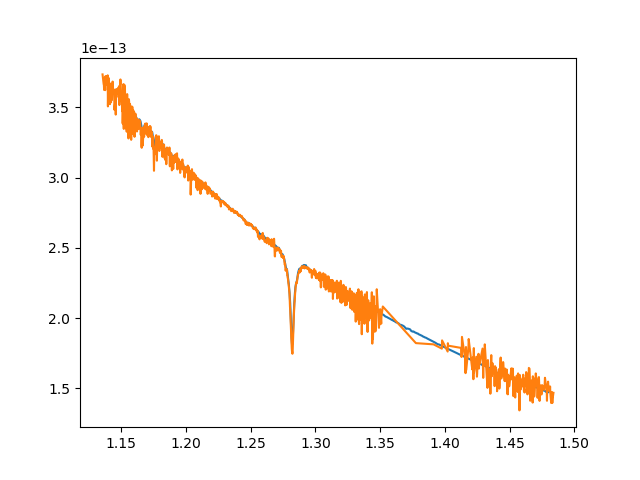

<IPython.core.display.Javascript object>


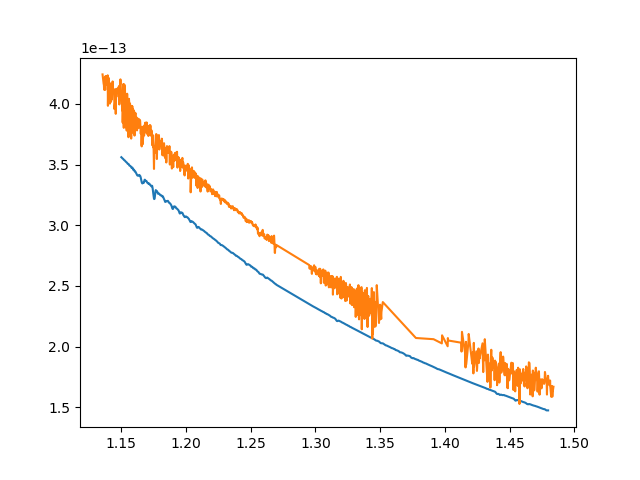

<IPython.core.display.Javascript object>


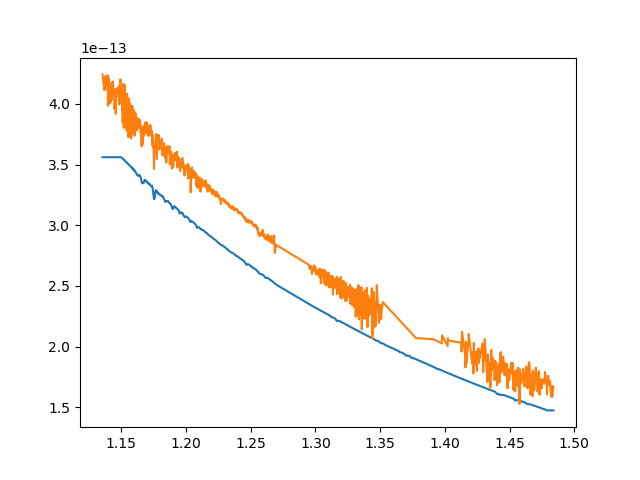

<IPython.core.display.Javascript object>


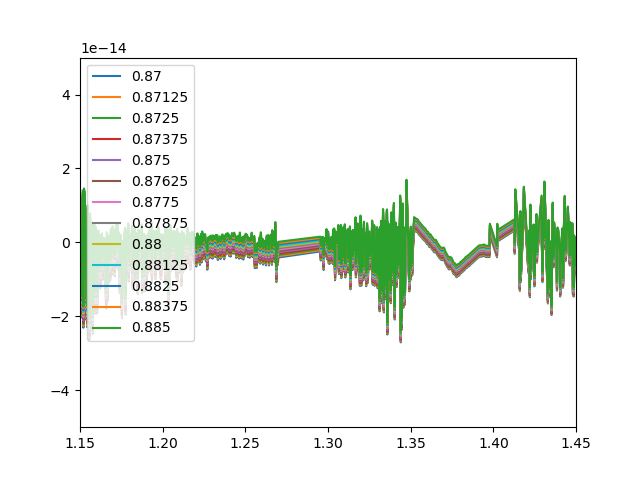

val: 0.87 avg: -3.83421320968e-15
val: 0.87125 avg: -3.48928004194e-15
val: 0.8725 avg: -3.14434687421e-15
val: 0.87375 avg: -2.79941370648e-15
val: 0.875 avg: -2.45448053874e-15
val: 0.87625 avg: -2.10954737101e-15
val: 0.8775 avg: -1.76461420327e-15
val: 0.87875 avg: -1.41968103554e-15
val: 0.88 avg: -1.07474786781e-15
val: 0.88125 avg: -7.29814700073e-16
val: 0.8825 avg: -3.84881532339e-16
val: 0.88375 avg: -3.99483646048e-17
val: 0.885 avg: 3.04984803129e-16


<IPython.core.display.Javascript object>


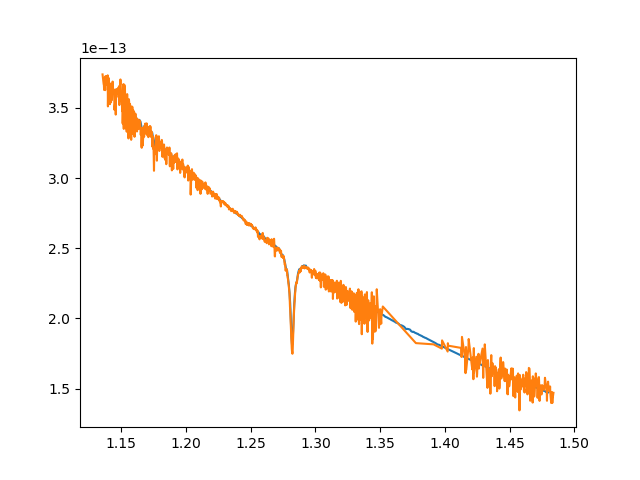

In [63]:
vega_order5_wav = [awi0005x3s_20171104_modVega_merged.wav[i] for i in range(awi0005x3s_20171104_modVega_merged.wav.size) if ((awi0005x3s_20171104_modVega_merged.wav[i] > 1.15) and (awi0005x3s_20171104_modVega_merged.wav[i] < 1.48))]
vega_order5_flux = [awi0005x3s_20171104_modVega_merged.flux[i] for i in range(awi0005x3s_20171104_modVega_merged.wav.size) if ((awi0005x3s_20171104_modVega_merged.wav[i] > 1.15) and (awi0005x3s_20171104_modVega_merged.wav[i] < 1.48))]

#line_regions_list = [(1.8, 1.835), (1.72, 1.755), (1.665, 1.6975), (1.63, 1.6525), (1.6025, 1.62), (1.58, 1.5975), (1.5625, 1.5775)]

vega_order5_wav_use = np.array(vega_order5_wav)
vega_order5_flux_use = np.array(vega_order5_flux)

wav_use = np.array([HD74562_20171104_raw_orders.order5.wav[i] for i in range(HD74562_20171104_raw_orders.order5.wav.size) if (HD74562_20171104_raw_orders.order5.snr[i] > 200.)])
flux_use = np.array([HD74562_20171104_raw_orders.order5.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order5.wav.size) if (HD74562_20171104_raw_orders.order5.snr[i] > 200.)])


possible_vals = np.linspace(0.87, 0.885, 13)

plt.figure()
plt.plot(vega_order5_wav_use, vega_order5_flux_use)
plt.plot(wav_use, flux_use*0.88)
plt.show()

#for bounds in line_regions_list:
#    lowbound, highbound = bounds
#    vega_order4_wav_use, vega_order4_flux_use = cut_region_out(vega_order4_wav_use, vega_order4_flux_use, lowbound, highbound)
#    wav_use, flux_use = cut_region_out(wav_use, flux_use, lowbound, highbound)    
    
vega_order5_wav_use, vega_order5_flux_use = cut_region_out(vega_order5_wav_use, vega_order5_flux_use, 1.27, 1.295)
wav_use, flux_use = cut_region_out(wav_use, flux_use, 1.27, 1.295)
    
plt.figure()
plt.plot(vega_order5_wav_use, vega_order5_flux_use)
plt.plot(wav_use, flux_use)
plt.show()

combined_grid_after_line_removal = insort(vega_order5_wav_use, wav_use)

vega_after_line_removal = np.interp(combined_grid_after_line_removal, vega_order5_wav_use, vega_order5_flux_use)
HD74562_after_line_removal = np.interp(combined_grid_after_line_removal, wav_use, flux_use)

plt.figure()
plt.plot(combined_grid_after_line_removal, vega_after_line_removal)
plt.plot(combined_grid_after_line_removal, HD74562_after_line_removal)
plt.show()

plt.figure()

for val in possible_vals:
    HD74562_scaled = HD74562_after_line_removal * val
    
    #print combined_grid_after_line_removal.size
    #print HD74562_scaled.size
    #print vega_after_line_removal.size

    plt.plot(combined_grid_after_line_removal, HD74562_scaled - vega_after_line_removal,label=str(val))
    
    #vals_used_in_average = np.interp(grid_use, combined_order_grid, (flux_use_interp - awi0005x3s_order_interp_flux))
    
    print "val:", val, "avg:", np.sum(HD74562_scaled - vega_after_line_removal)/HD74562_scaled.size

plt.xlim([1.15,1.45])
plt.ylim([-5.0e-14, 5.0e-14])
plt.legend(loc='upper left')
plt.show()

vega_order5_wav_use = np.array(vega_order5_wav)
vega_order5_flux_use = np.array(vega_order5_flux)

wav_use = np.array([HD74562_20171104_raw_orders.order5.wav[i] for i in range(HD74562_20171104_raw_orders.order5.wav.size) if (HD74562_20171104_raw_orders.order5.snr[i] > 200.)])
flux_use = np.array([HD74562_20171104_raw_orders.order5.flux_ergs[i] for i in range(HD74562_20171104_raw_orders.order5.wav.size) if (HD74562_20171104_raw_orders.order5.snr[i] > 200.)])


plt.figure()
plt.plot(vega_order5_wav_use, vega_order5_flux_use)
plt.plot(wav_use, flux_use*0.881)
plt.show()

In [ ]:
awi0005x3s_20171104_merged = import_arcoiris_from_text('AWI0005x3s_xtc_20171104_merged.txt','AWI0005x3s','2017-11-04')
awi0005x3s_20180301_merged = import_arcoiris_from_text('AWI0005x3s_xtc_20180301_merged.txt','AWI0005x3s','2018-03-01')
awi0005x3s_20180302_merged = import_arcoiris_from_text('AWI0005x3s_xtc_20180302_merged.txt','AWI0005x3s','2018-03-02')

template_spectrum = import_spex_spectrum_from_file('M5V_Gl866ABC.txt')

awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use, awi0005x3s_20171104_err_use = awi0005x3s_20171104_merged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180301_wav_use, awi0005x3s_20180301_flux_use, awi0005x3s_20180301_err_use = awi0005x3s_20180301_merged.get_snr_cut_spectrum_watts(20.)
awi0005x3s_20180302_wav_use, awi0005x3s_20180302_flux_use, awi0005x3s_20180302_err_use = awi0005x3s_20180302_merged.get_snr_cut_spectrum_watts(20.)


telluric_wavs = [awi0005x3s_20171104_merged.wav[i] for i in range(awi0005x3s_20171104_merged.wav.size) if awi0005x3s_20171104_merged.wav[i] not in awi0005x3s_20171104_wav_use]

#print telluric_wavs

plt.figure(figsize=(15,7.5))
plt.plot(awi0005x3s_20171104_merged.wav, awi0005x3s_20171104_merged.flux)
plt.plot(awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use/10.)
#plt.xlim([1.1,1.2])
#plt.xlim([2.25,2.5])
plt.ylim([0.,1.0e-14])
plt.show()

#i = 1
#while i < (len(awi0005x3s_20171104_wav_use) - 1):
#    if (awi0005x3s_20171104_wav_use[i+1] - awi0005x3s_20171104_wav_use[i]) > (5.*(awi0005x3s_20171104_wav_use[i] - awi0005x3s_20171104_wav_use[i-1])):
#        telluric_wavs.append(awi0005x3s_20171104_wav_use[i])
#        telluric_wavs.append(awi0005x3s_20171104_wav_use[i+1])
        
#    i+=1
    
#print 'telluric_wavs:', telluric_wavs


combined_grid_mdwarf = insort(awi0005x3s_20171104_wav_use, template_spectrum.full_wavelength[370:4377])

template_spectrum_combined_grid_flux = np.interp(combined_grid_mdwarf, template_spectrum.full_wavelength, template_spectrum.full_flux_density)
awi0005x3s_20171104_combined_grid_flux_use = np.interp(combined_grid_mdwarf, awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)

plt.figure(figsize=(20.,10.))
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density, 'k')
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')
plt.plot(awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)
plt.plot(combined_grid_mdwarf, template_spectrum_combined_grid_flux,'k')
plt.plot(combined_grid_mdwarf, awi0005x3s_20171104_combined_grid_flux_use)
plt.xlim([0.8,2.4])
#plt.ylim([0.,3.5e-14])
plt.yscale("log",nonposy='clip')
plt.title('2017-11-04')
plt.show()

div = awi0005x3s_20171104_combined_grid_flux_use / template_spectrum_combined_grid_flux

plt.figure(figsize=(15., 7.5))
plt.plot(combined_grid_mdwarf, div)
plt.show()

plt.figure(figsize=(20.,10.))
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0026,'k')
plt.plot(awi0005x3s_20180301_wav_use, awi0005x3s_20180301_flux_use)
plt.xlim([0.8,2.4])
plt.ylim([0.,3.5e-14])
plt.title('2018-03-01')
plt.show()

plt.figure(figsize=(20.,10.))
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.00245,'k')
plt.plot(awi0005x3s_20180302_wav_use, awi0005x3s_20180302_flux_use)
plt.xlim([0.8,2.4])
plt.ylim([0.,3.5e-14])
plt.title('2018-03-02')
plt.show()

plt.figure(figsize=(20.,10.))
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')
plt.plot(awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)
plt.plot(awi0005x3s_20180301_wav_use, awi0005x3s_20180301_flux_use*(0.0025/0.0026))
plt.plot(awi0005x3s_20180302_wav_use, awi0005x3s_20180302_flux_use*(0.0025/0.00245))
plt.xlim([0.8,2.4])
plt.ylim([0.,3.5e-14])
plt.show()

plt.figure(figsize=(16.,9.))
plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')
plt.plot(awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)
plt.plot(awi0005x3s_20180301_wav_use, awi0005x3s_20180301_flux_use*(0.0025/0.0026))
plt.plot(awi0005x3s_20180302_wav_use, awi0005x3s_20180302_flux_use*(0.0025/0.00245))
plt.xlim([2.05,2.4])
plt.ylim([0.4e-14,1.0e-14])
plt.show()





#print min(awi0005x3s_20171104_wav_use), max(awi0005x3s_20171104_wav_use)
#print min(template_spectrum.full_wavelength), max(template_spectrum.full_wavelength)

#print template_spectrum.full_wavelength[370], template_spectrum.full_wavelength[4376]

#tempgrid = np.linspace(0.9,2.4,10000.)
#template_flux_rebinned = np.interp(combined_grid, template_spectrum.full_wavelength, template_spectrum.full_flux_density)
#template_err_rebinned = np.interp(combined_grid, template_spectrum.full_wavelength, template_spectrum.full_error)
#target_flux_rebinned = np.interp(combined_grid, awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)
#target_err_rebinned = np.interp(combined_grid, awi0005x3s_20171104_wav_use, awi0005x3s_20171104_err_use)

#plt.figure()
#plt.plot(combined_grid, template_flux_rebinned*0.0025)
#plt.plot(combined_grid, target_flux_rebinned)
#plt.show()

#subtracted_flux = target_flux_rebinned - (0.0025*template_flux_rebinned)
#subtraction_err = np.power((np.power(target_err_rebinned,2)+np.power((0.0025*template_err_rebinned),2.)),0.5)
#subtraction_snr = subtracted_flux / subtraction_err

#plt.figure()
#plt.plot(combined_grid, (target_flux_rebinned - (0.0025*template_flux_rebinned)))

#plt.plot(combined_grid, subtraction_err)
#plt.show()

#plt.figure()
#plt.plot(combined_grid, subtraction_snr)
#plt.plot(combined_grid, np.ones(combined_grid.size)*3.)
#plt.xlim([2.1,2.2])
#plt.show()

In [ ]:
plt.figure(figsize=(15.,7.5))
plt.plot(HD74562_20171104_merged_revised.wav, HD74562_20171104_merged_revised.flux)
plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux/0.875)
plt.plot(awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)
#plt.plot(HD74562_20171104_merged.wav, HD74562_20171104_merged.flux*0.88)
plt.xlim([0.8,2.4])
#plt.ylim([2.5e-14,1.5e-12])
plt.xlabel('Wavelength (microns)',fontsize=16)
plt.ylabel('Flux (arbitrary units)',fontsize=16)
plt.title('HD 74562 Compared to Model Spectrum',fontsize=18)
plt.yscale("log",nonposy='clip')
plt.show()

combined_grid = insort(HD74562_20171104_merged.wav, awi0005x3s_20171104_modVega_merged.wav)

HD74562_flux_interp = np.interp(combined_grid, HD74562_20171104_merged_revised.wav, HD74562_20171104_merged_revised.flux)
awi0005x3s_flux_interp = np.interp(combined_grid, awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)

#dif = (HD74562_flux_interp*0.88) - awi0005x3s_flux_interp

zeros = np.zeros(combined_grid.size)

avg = np.sum(dif)/combined_grid.size
print avg

#plt.figure(figsize=(20.,10.))
#plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density, 'k')
#plt.plot(template_spectrum.full_wavelength, template_spectrum.full_flux_density*0.0025,'k')
#plt.plot(awi0005x3s_20171104_wav_use, awi0005x3s_20171104_flux_use)
#plt.plot(combined_grid_mdwarf, template_spectrum_combined_grid_flux,'k')
#plt.plot(combined_grid_mdwarf, awi0005x3s_20171104_combined_grid_flux_use)
#plt.xlim([0.8,2.4])
#plt.ylim([0.,3.5e-14])
#plt.yscale("log",nonposy='clip')
#plt.title('2017-11-04')
#plt.show()

combined_grid_use = []

for x in combined_grid:
    if x < 1.11 or (x > 1.16 and x < 1.345) or (x > 1.45 and x < 1.80) or (x > 1.95):
        combined_grid_use.append(x)
    
HD74562_flux_interp_use = np.interp(combined_grid_use, HD74562_20171104_merged.wav, HD74562_20171104_merged.flux)
awi0005x3s_flux_interp_use = np.interp(combined_grid_use, awi0005x3s_20171104_modVega_merged.wav, awi0005x3s_20171104_modVega_merged.flux)

div_a0v = HD74562_flux_interp_use / awi0005x3s_flux_interp_use
#comp = np.ones(combined_grid.size)/0.875
#comp1 = np.ones(combined_grid.size)*((1-(0.8785*0.01))/0.8785) + (0.01*combined_grid)
plt.figure(figsize=(15.,7.5))
plt.plot(combined_grid_use, div_a0v)
#plt.plot(combined_grid, comp,'k')
#plt.plot(combined_grid, comp1)
#plt.xlim([0.9,1.875])
plt.xlabel('Wavelength (microns)',fontsize=16)
plt.ylabel('Flux ratio')
plt.xlim([0.8,2.4])
plt.ylim([1.1,1.3])
plt.title('Observed A0V divided by Model A0V Spectrum',fontsize=18)
plt.show()

#plt.figure(figsize=(20.,10.))
#plt.plot(combined_grid, dif)
#plt.plot(combined_grid, zeros)
#plt.xlim([0.75,2.5])
#plt.ylim([-0.01e-12,1.0e-12])
#plt.show()

#plt.figure(figsize=(20.,10))
#plt.plot(combined_grid, ((div_a0v - comp)/comp))
#plt.show()

#avg_comps = np.sum(div_a0v)/div_a0v.size
#print avg

#avg_err = np.sum((div_a0v - comp)/comp)/div_a0v.size

#err = (div_a0v - comp)/comp

#dif_div = div_a0v - comp

#plt.figure()
#plt.plot(combined_grid, dif_div)
#plt.ylim([-0.25,0.25])
#plt.show()

#err_use = np.array([err[i] for i in range(err.size) if not math.isnan(err[i])])

#square_err = err_use**2

#sum_square_err = np.sum(square_err)
#print sum_square_err

#mean_square_err = sum_square_err/square_err.size
#print mean_square_err

#rmse = np.sqrt(mean_square_err)
#print rmse


div_mdwarf = awi0005x3s_20171104_combined_grid_flux_use / template_spectrum_combined_grid_flux

plt.figure(figsize=(15., 7.5))
plt.plot(combined_grid_mdwarf, div)
plt.xlabel('Wavelength (microns)',fontsize=16)
plt.ylabel('Flux ratio', fontsize=16)
plt.xlim([0.8,2.4])
plt.title('AWI0005x3s Divided by Template Spectrum', fontsize=18)
plt.show()